In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os

import scipy.stats as stats
import warnings

from matplotlib import pyplot as plt
from dotenv import load_dotenv
from sklearn.decomposition import PCA
from sklearn import preprocessing

from scripts.pca_fn import show_contribution, display_circles
from scripts.cleaning import remove_outliers, scale_df


load_dotenv()
plt.style.use('Solarize_Light2')
sns.color_palette("colorblind")

warnings.filterwarnings('ignore')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


# Override max dpi

if pc_dpi > 155:
    pc_dpi = 155


In [2]:
# File

sea_ds = "./data/seattle_data.csv"

df_seattle = pd.read_csv(sea_ds)


In [3]:
df_seattle.shape


(1099, 22)

# <u>Analyse exploratoire :</u>

## <u>0. Elimination d'aberrations via IQR</u>

## <u>1. Age des batiments </u>
- <u>1.a : Représentation des batiments en fonction de leurs dates de construction. </u>
- <u>1.b : Visualisation des statistiques principales de la variable : Energie par metre carré </u>
- <u>1.c : Paire 1.a 1.b : Date de construction et utilisation en energie par metre carré | Emission de GES par m2. </u>

<hr>

## <u> 2. Etude de la note Energy Star</u>
- <u> 2.a : Repartition de la note Energy Star au sein des données. </u>
- <u> 2.b : Paire 2 : Note Energy Star en fonction de l'energie par metre carré. </u>
- <u> 2.c : Paire 3 : Note Energy Star en fonction de l'intensité d'emissions de GES. </u>
- <u> 2.d : Paire 4 : Energy Star en fonction de l'année de construction. </u>

<hr>

## <u> 3 : Représentation Property Type/Utilisation Energie </u>
- <u> 3.a : Visualisation des categories principales </u>
- <u> 3.b : Etude en détails de la correllation taille -> E* </u>
- <u> 3.c : Etude en détails de la correllation taille -> GES </u>
- <u> 3.d : Etude en détails de la correllation taille -> EUI </u>

### One Hot Encoding des variables categorielles utiles
### Export 1 : dataset destine a la prediction EUI et GES

## <u> 4 : Reduction de dimension via ACP </u>
- <u> 4.a : Elimination des variables inutiles la modelisation </u>
- <u> 4.b : Realisation d'une ACP sur les variables restantes </u>

### Export 2 : dataset destine a la prediction de E*

### Cette analyse permettra de :
 - Visualiser "l'age" du paysage de Seattle
 - Contextualiser la mesure de la consommation d'énergie au metre carré, et sa possible relation avec l'age des batiments
 - Avoir une meilleure comprehension de la variable Energy Star et de la présenter face à l'age des batiments et de leur consommation en energie


## 0. Elimination d'outliers via la methode interquartile :


In [4]:
cleaning_list = ["Electricity(kWh)", "SourceEUI(kWh/m2)", "SiteEnergyUse(kWh)"]

for col in cleaning_list:
    remove_outliers(col, df_seattle)

print(df_seattle.shape)

print(f"{1099 - df_seattle.shape[0]} buildings deleted")


(868, 22)
231 buildings deleted


## 1. Age des batiments

### 1.a : Représentation des batiments en fonction de leurs dates de construction.

In [5]:
data_age = list(df_seattle["YearBuilt"].astype(int))
oldest = min(data_age)
youngest = max(data_age)

print(f"Le plus ancien batiment date de {oldest}, le plus récent (donnees de 2016) date de {youngest}")


Le plus ancien batiment date de 1900, le plus récent (donnees de 2016) date de 2015


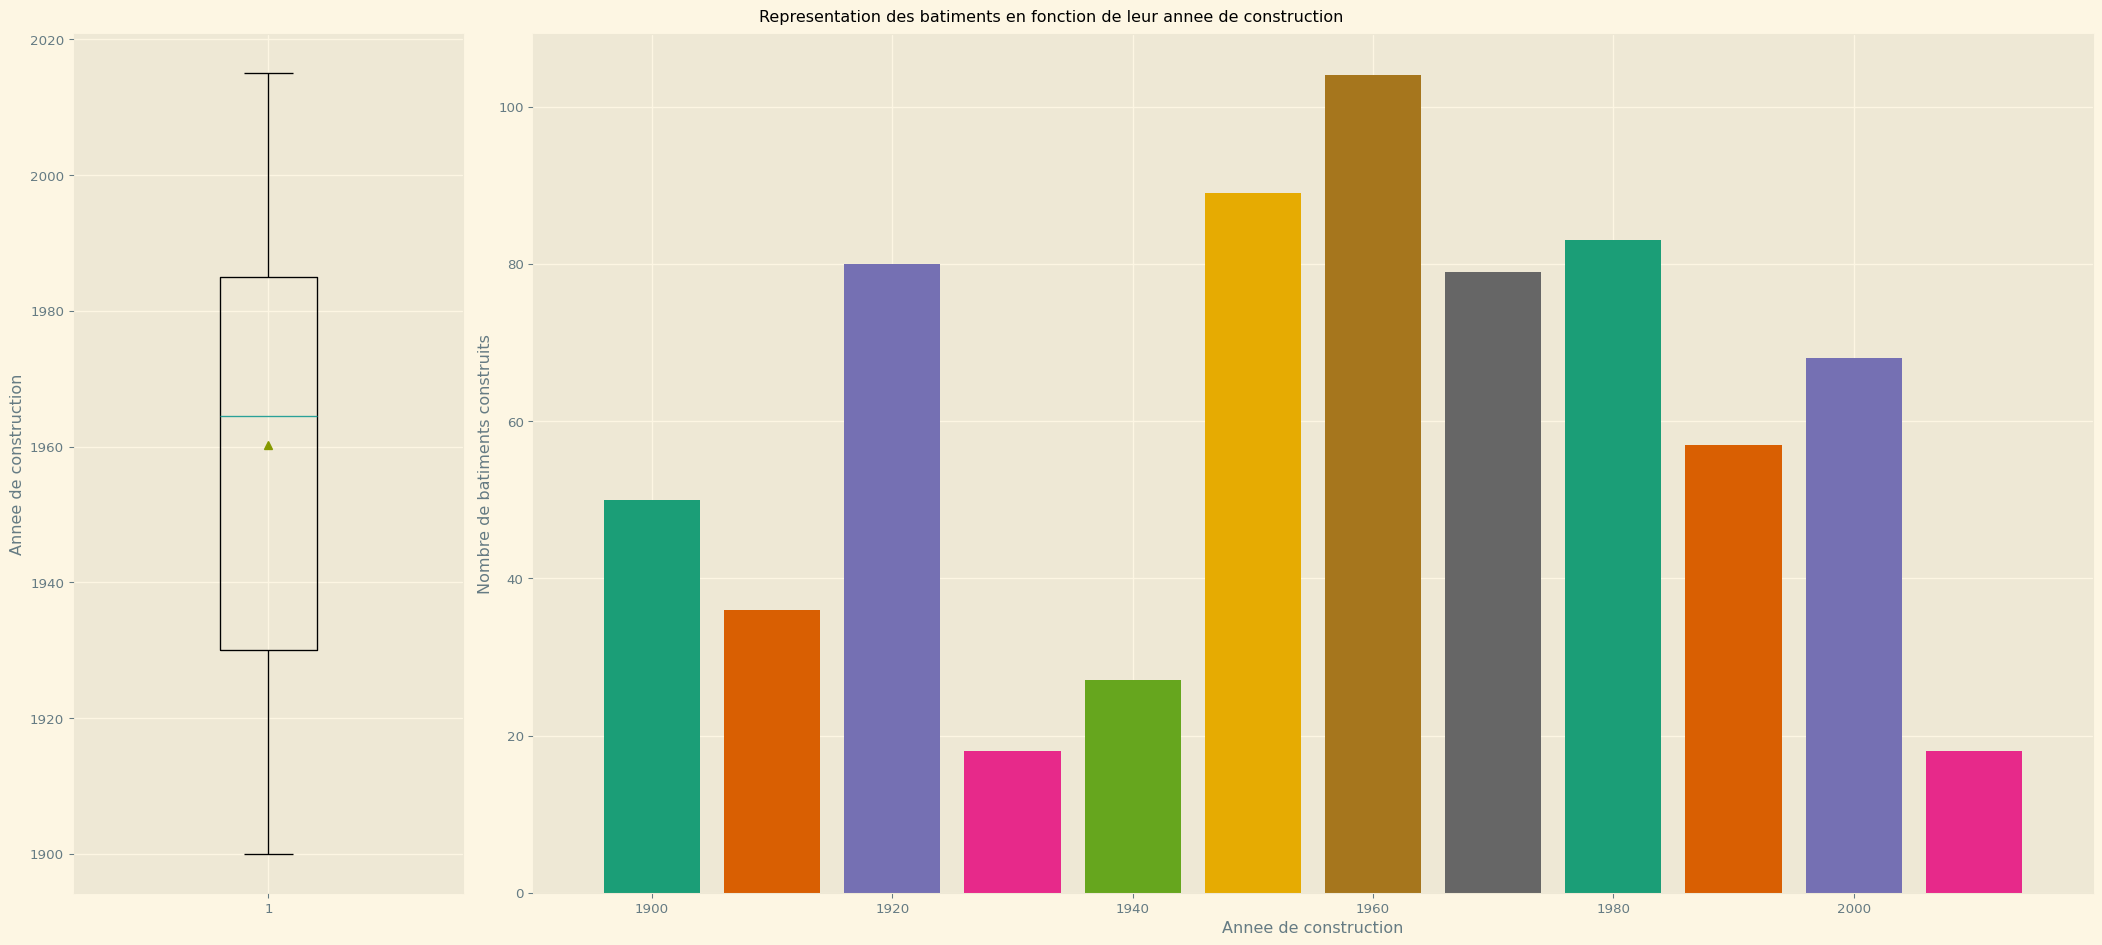

In [6]:
decades = np.arange(1900, 2020, 10)

building_per_decade = dict.fromkeys(decades)

for decade in building_per_decade.keys():
    built = len([year for year in data_age if (year > decade and year < decade + 10)])
    building_per_decade[decade] = built

used_cmap = plt.get_cmap("Dark2")

fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(22, 10),
    gridspec_kw={"width_ratios": [1, 4]},
    dpi=pc_dpi
    )

ax1.boxplot(data_age, showmeans=True, widths=0.25)

ax2.bar(building_per_decade.keys(), height=building_per_decade.values(), width=8, color=used_cmap.colors)
# ax2 lineplot

###
# Titles & Labels
ax1.set_ylabel("Annee de construction")
ax2.set_ylabel("Nombre de batiments construits")
ax2.set_xlabel("Annee de construction")
fig.suptitle("Representation des batiments en fonction de leur annee de construction")
fig.tight_layout()
#
###

plt.show()

#### Observations :

- Le paysage urbanin de Seattle date, majoritairement (q1, q3) de 1939 - 1990 (moyenne en 1965)
- On remarque une logique économique : pic de construction dans les années 20 (Roaring 20s) suivi par un creux dans les années 30 (Grande Depression)
- De nombreux projets date de du debut du millénaire, la decenie 2010+ n'est pas étudiable : les données s'arretent en 2015

### 1.b : Visualisation des statistiques principales de la variable : Energie par metre carré

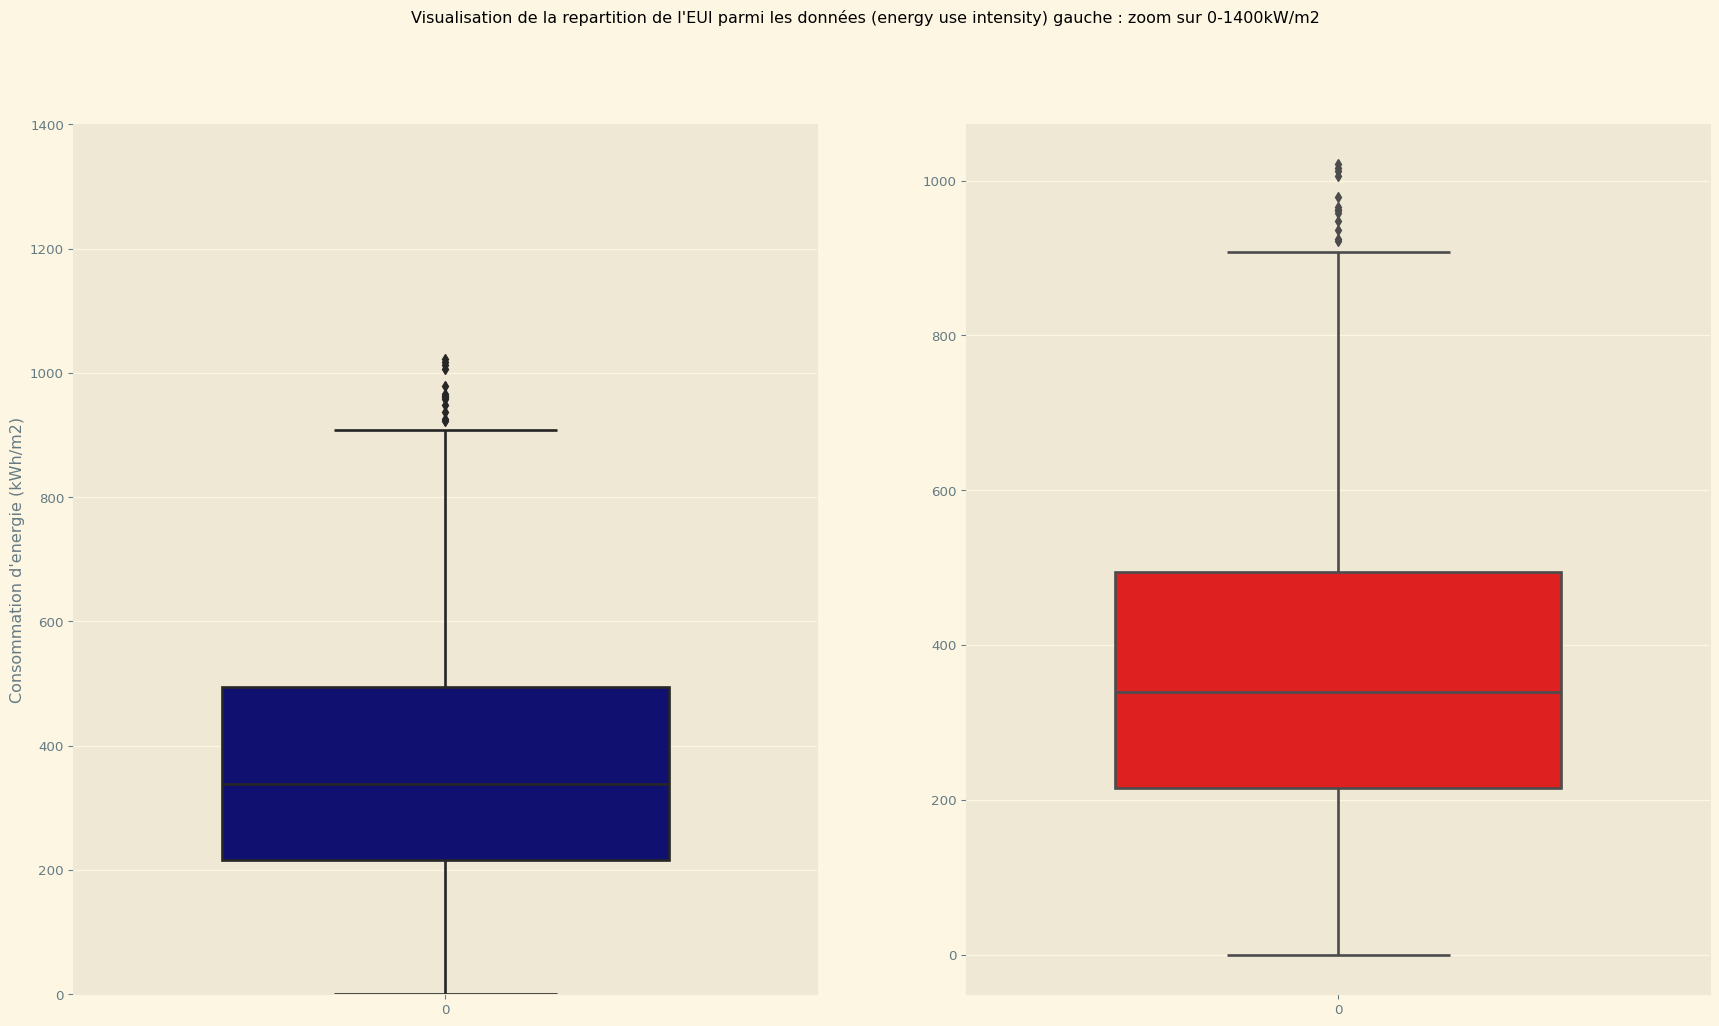

count     868.000000
mean      369.994519
std       203.217937
min         0.000000
25%       215.616228
50%       338.645244
75%       494.797449
max      1021.771682
Name: SourceEUI(kWh/m2), dtype: float64


In [7]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
    )

source_eui_data = list(df_seattle["SourceEUI(kWh/m2)"].values.astype(float))

sns.boxplot(data=source_eui_data, width=0.6, ax=ax1, color="navy")
ax1.set_ylim(0, 1400)  # High number of outliers, cf describe
sns.boxplot(data=source_eui_data, width=0.6, ax=ax2, color="red")
# fig.tight_layout()

###
# Titles/Lables
ax1.set_ylabel("Consommation d'energie (kWh/m2)")
fig.suptitle("Visualisation de la repartition de l'EUI parmi les données (energy use intensity)\
 gauche : zoom sur 0-1400kW/m2")
#
###

plt.show()

print(df_seattle["SourceEUI(kWh/m2)"].astype(float).describe())


#### Analyse :

- 1 : Les outliers sont extrèmement nombreux, uniquement dans les utilisations "hautes"
- 2 : La majorité des batiments ont une EUI entre 215 et 494 kWh/m2, 369 en moyenne.
- 3 : L'élimination de batiments via la methode interquartile peut être viable, la reduction de dimension via ACP peut également être une piste


### 1.c : Paire 1 : Date de construction et EUI | GES/m2

In [8]:
df_seattle.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'LargestPropertyUseType', 'ENERGYSTARScore', 'Electricity(kWh)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'PropertyArea(SquareMetre)Total', 'PropertyArea(SquareMetre)Parking',
       'PropertyArea(SquareMetre)Building(s)',
       'LargestPropertyUseTypeArea(SquareMetre)', 'SourceEUI(kWh/m2)',
       'SourceEUIWN(kWh/m2)', 'SiteEnergyUse(kWh)', 'SiteEnergyUseWN(kWh)',
       'NaturalGas(kWh)'],
      dtype='object')

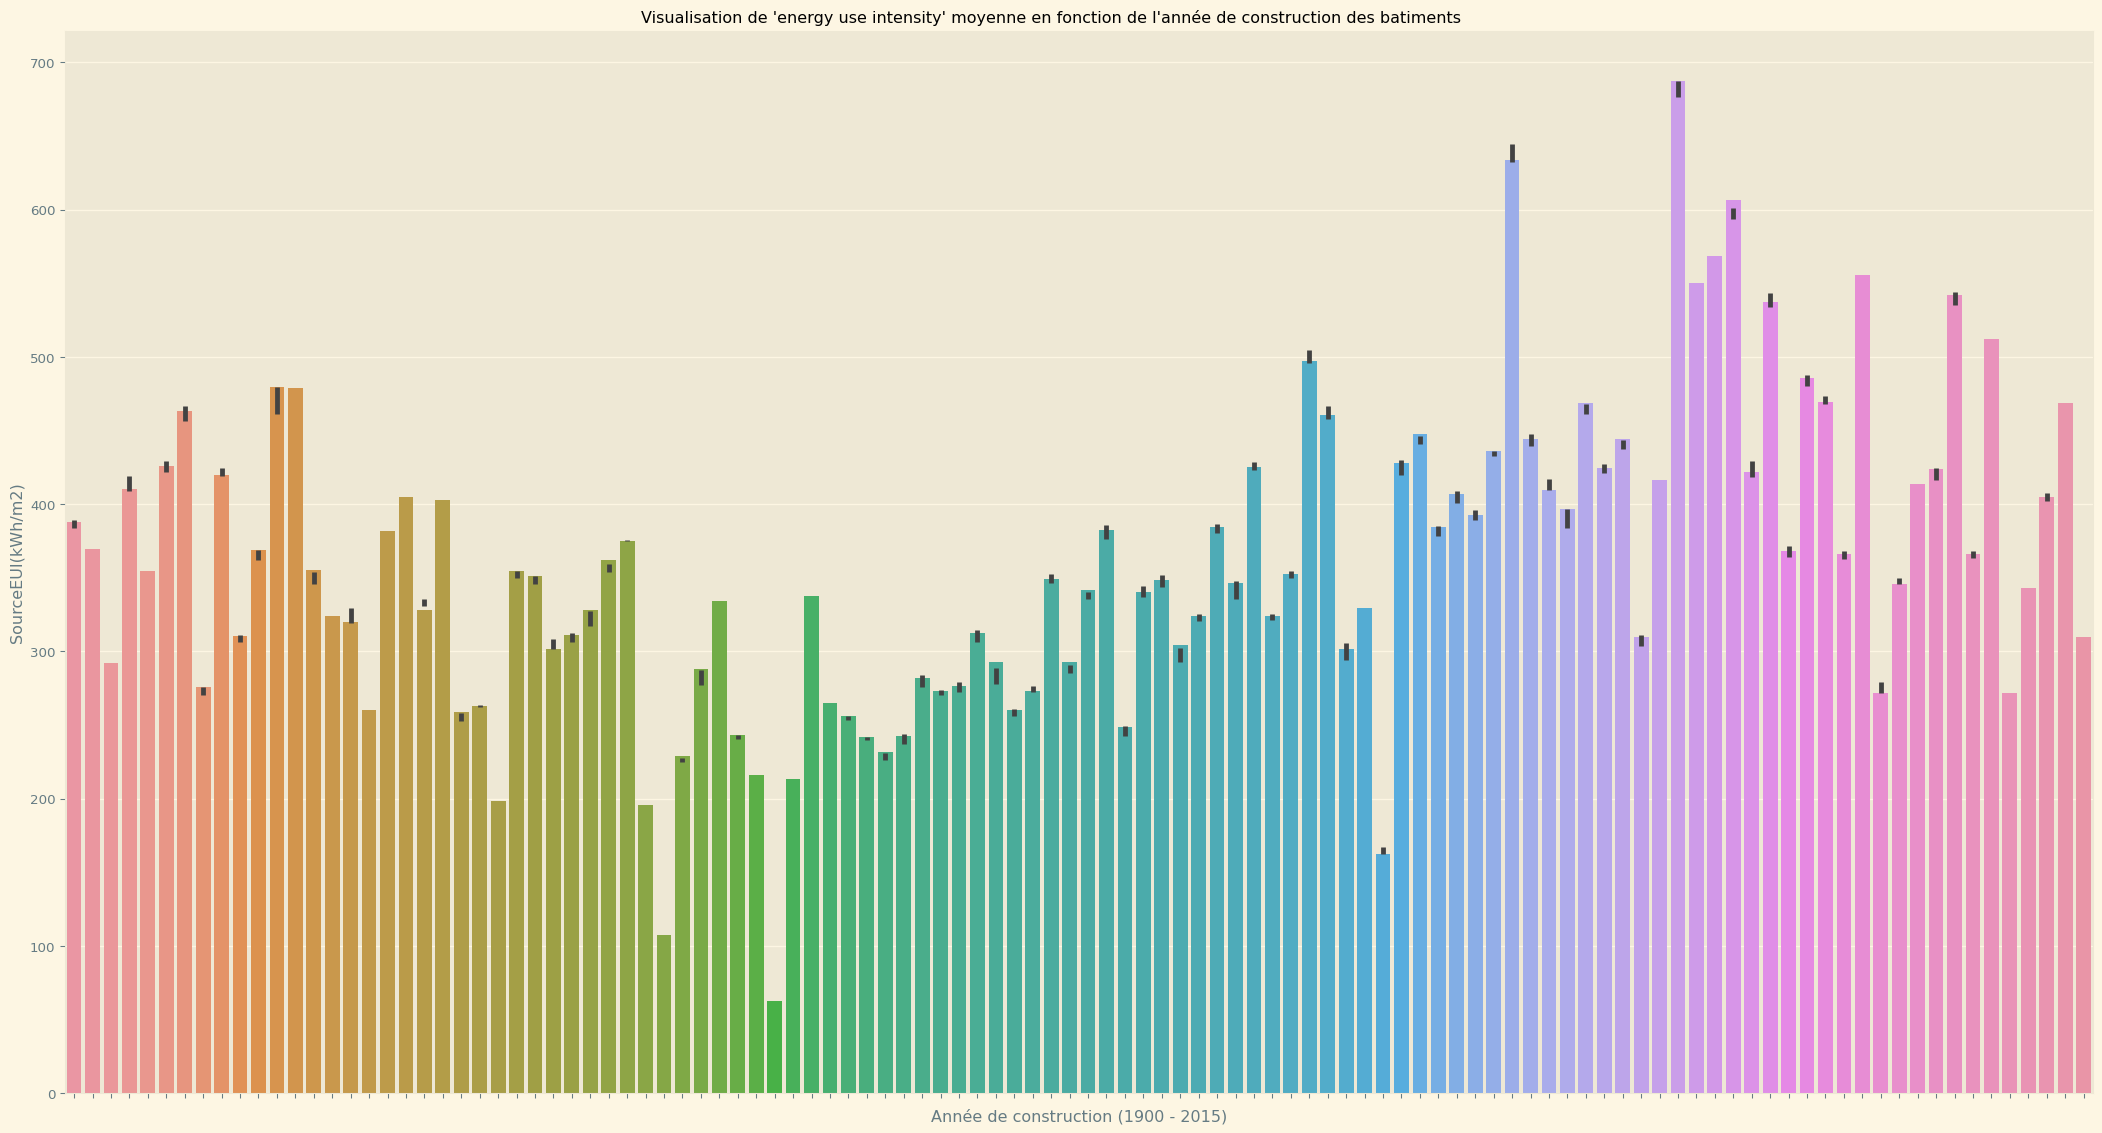

In [9]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x=df_seattle["YearBuilt"].astype(int).values,
    y=df_seattle["SourceEUI(kWh/m2)"].values.astype(float),
    ci=5
)

###
# Titles/Lables
ax1.set_xticklabels([])
ax1.set_ylabel("SourceEUI(kWh/m2)")
ax1.set_xlabel("Année de construction (1900 - 2015)")
fig.suptitle("Visualisation de 'energy use intensity' moyenne en fonction de l'année de construction des batiments")

#
###
fig.tight_layout()
plt.show()


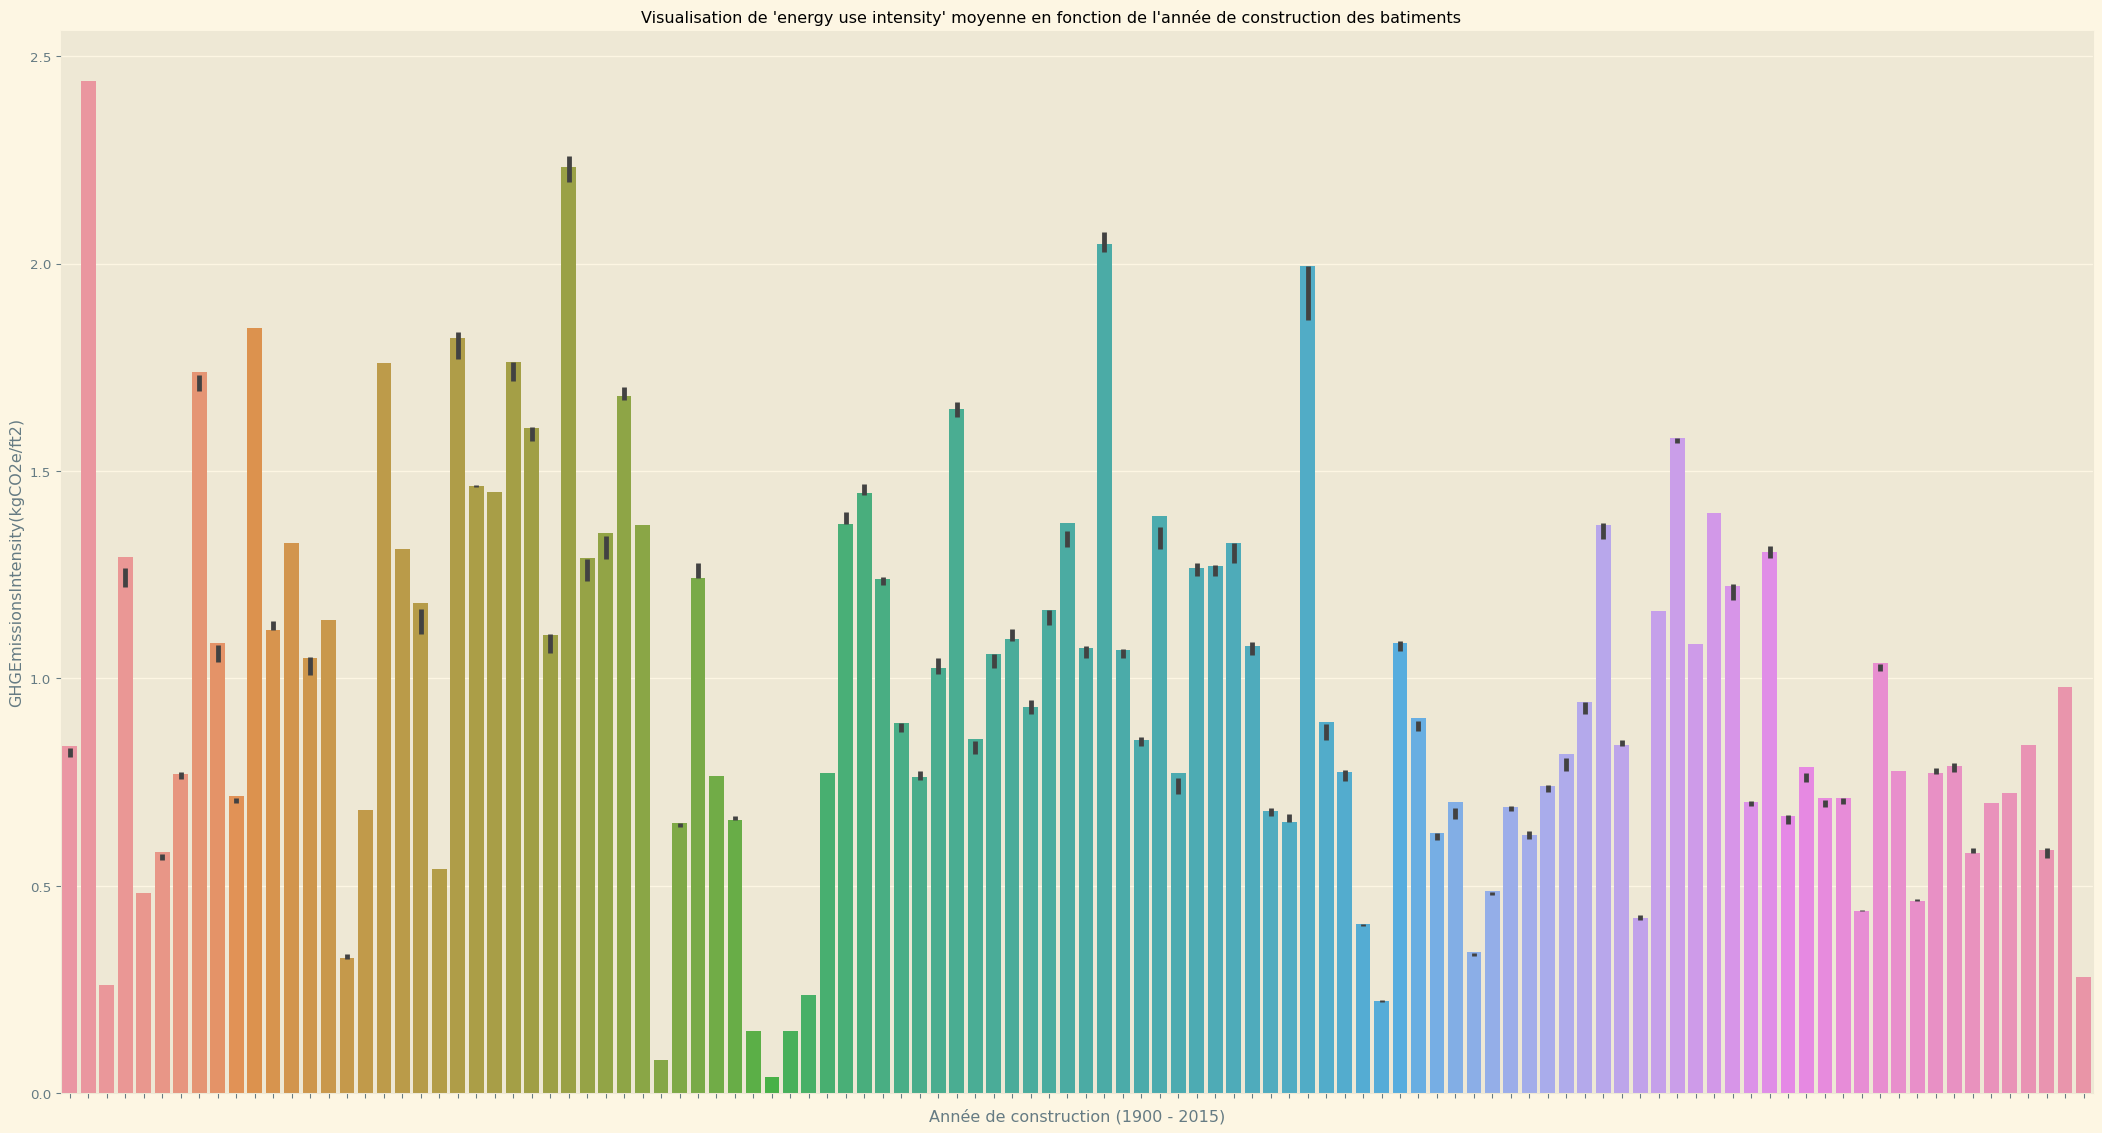

In [10]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x=df_seattle["YearBuilt"].astype(int).values,
    y=df_seattle["GHGEmissionsIntensity(kgCO2e/ft2)"].values.astype(float),
    ci=5
)

###
# Titles/Lables
ax1.set_xticklabels([])
ax1.set_ylabel("GHGEmissionsIntensity(kgCO2e/ft2)")
ax1.set_xlabel("Année de construction (1900 - 2015)")
fig.suptitle("Visualisation de 'energy use intensity' moyenne en fonction de l'année de construction des batiments")

#
###
fig.tight_layout()
plt.show()


#### Observation : 
- L'age des batiments ne semble pas avoir d'impact sur leur intensité d'utilisation énergétique. On peut emettre l'hypothèse que les batiments les plus anciens ont été modernisés pour avoir une consommation energetique plus responsable.
- Les batiments les plus modernes semblent rejetter moins de GES que les batiments plus anciens (nouveaux materiaux ? nouvelles techniques de construction ?)

## 2. Etude de la note Energy Star

### 2.a : Repartition de la note Energy Star au sein des données


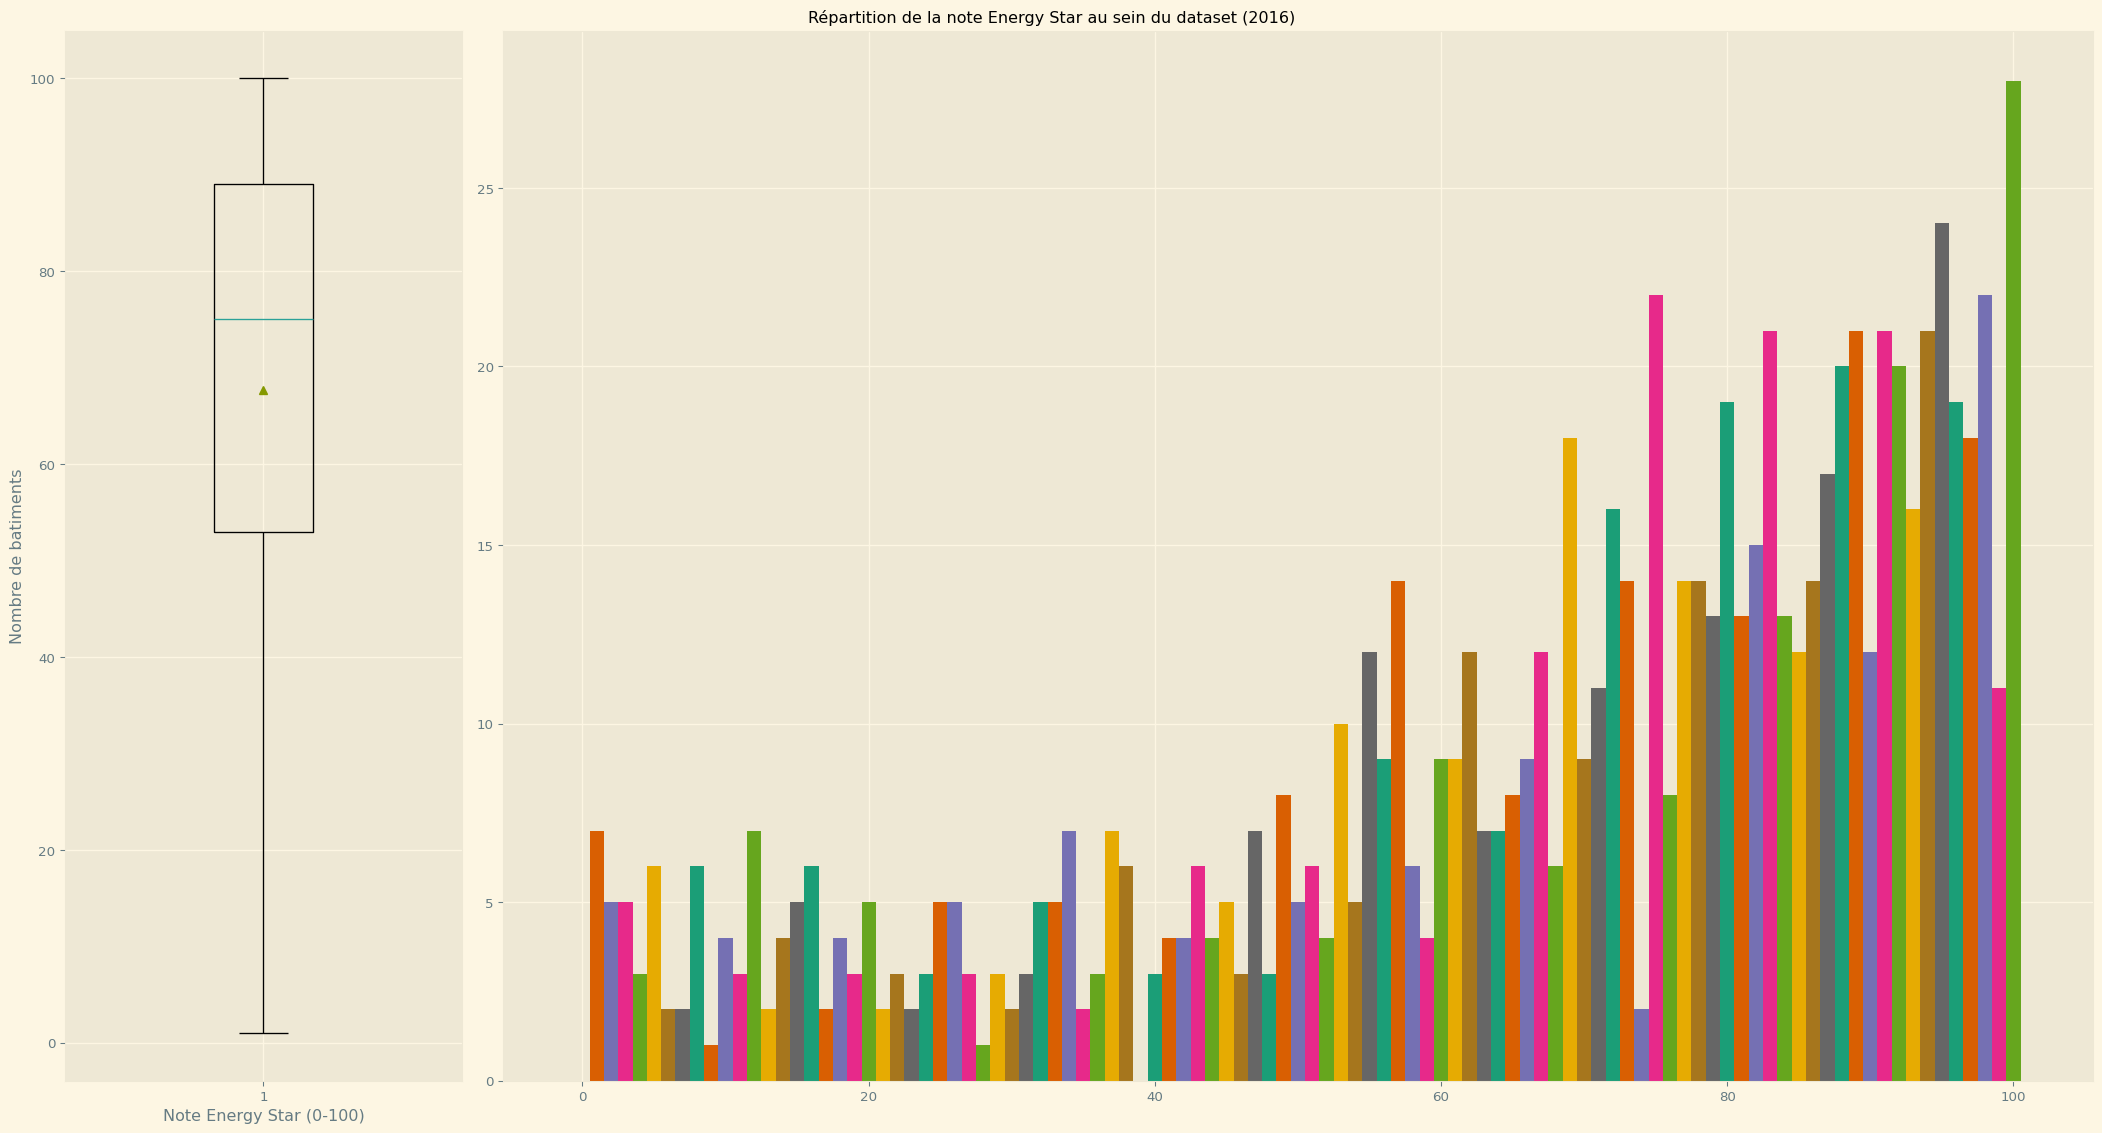

count    868.000000
mean      67.682028
std       26.878046
min        1.000000
25%       53.000000
50%       75.000000
75%       89.000000
max      100.000000
Name: ENERGYSTARScore, dtype: float64

In [11]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(22, 12),
    gridspec_kw={"width_ratios": [1, 4]},
    dpi=pc_dpi,
)

rated = df_seattle[df_seattle["ENERGYSTARScore"].notna()]
scores = list(rated["ENERGYSTARScore"].astype(int).values)
score_range = range(0, 101, 1)
scores_dict = dict.fromkeys(score_range)

for score in scores_dict.keys():
    scores_dict[score] = scores.count(score)

ax1.boxplot(scores, showmeans=True, widths=0.25)

ax2.bar(
    x=list(scores_dict.keys()),
    height=list(scores_dict.values()),
    color=used_cmap.colors,
    width=1
    )

####
## Titles/Lables
ax1.set_ylabel("Nombre de batiments")
ax1.set_xlabel("Note Energy Star (0-100)")
fig.suptitle("Répartition de la note Energy Star au sein du dataset (2016)")
##
####

fig.tight_layout()

plt.show()

rated["ENERGYSTARScore"].describe()


#### Observations :
- Les notes sont globalement hautes (Q1=53-Q3=89) - Les batiments ont le droit d'afficher le label "Energy Star Certified" si leur note est superieure ou égale a 75 -> Mediane (sources), motivation pour chercher a atteindre ce score.
- Variance haute (26).

### 2.b : Paire 2 : Note Energy Star en fonction de l'energie par metre carré.

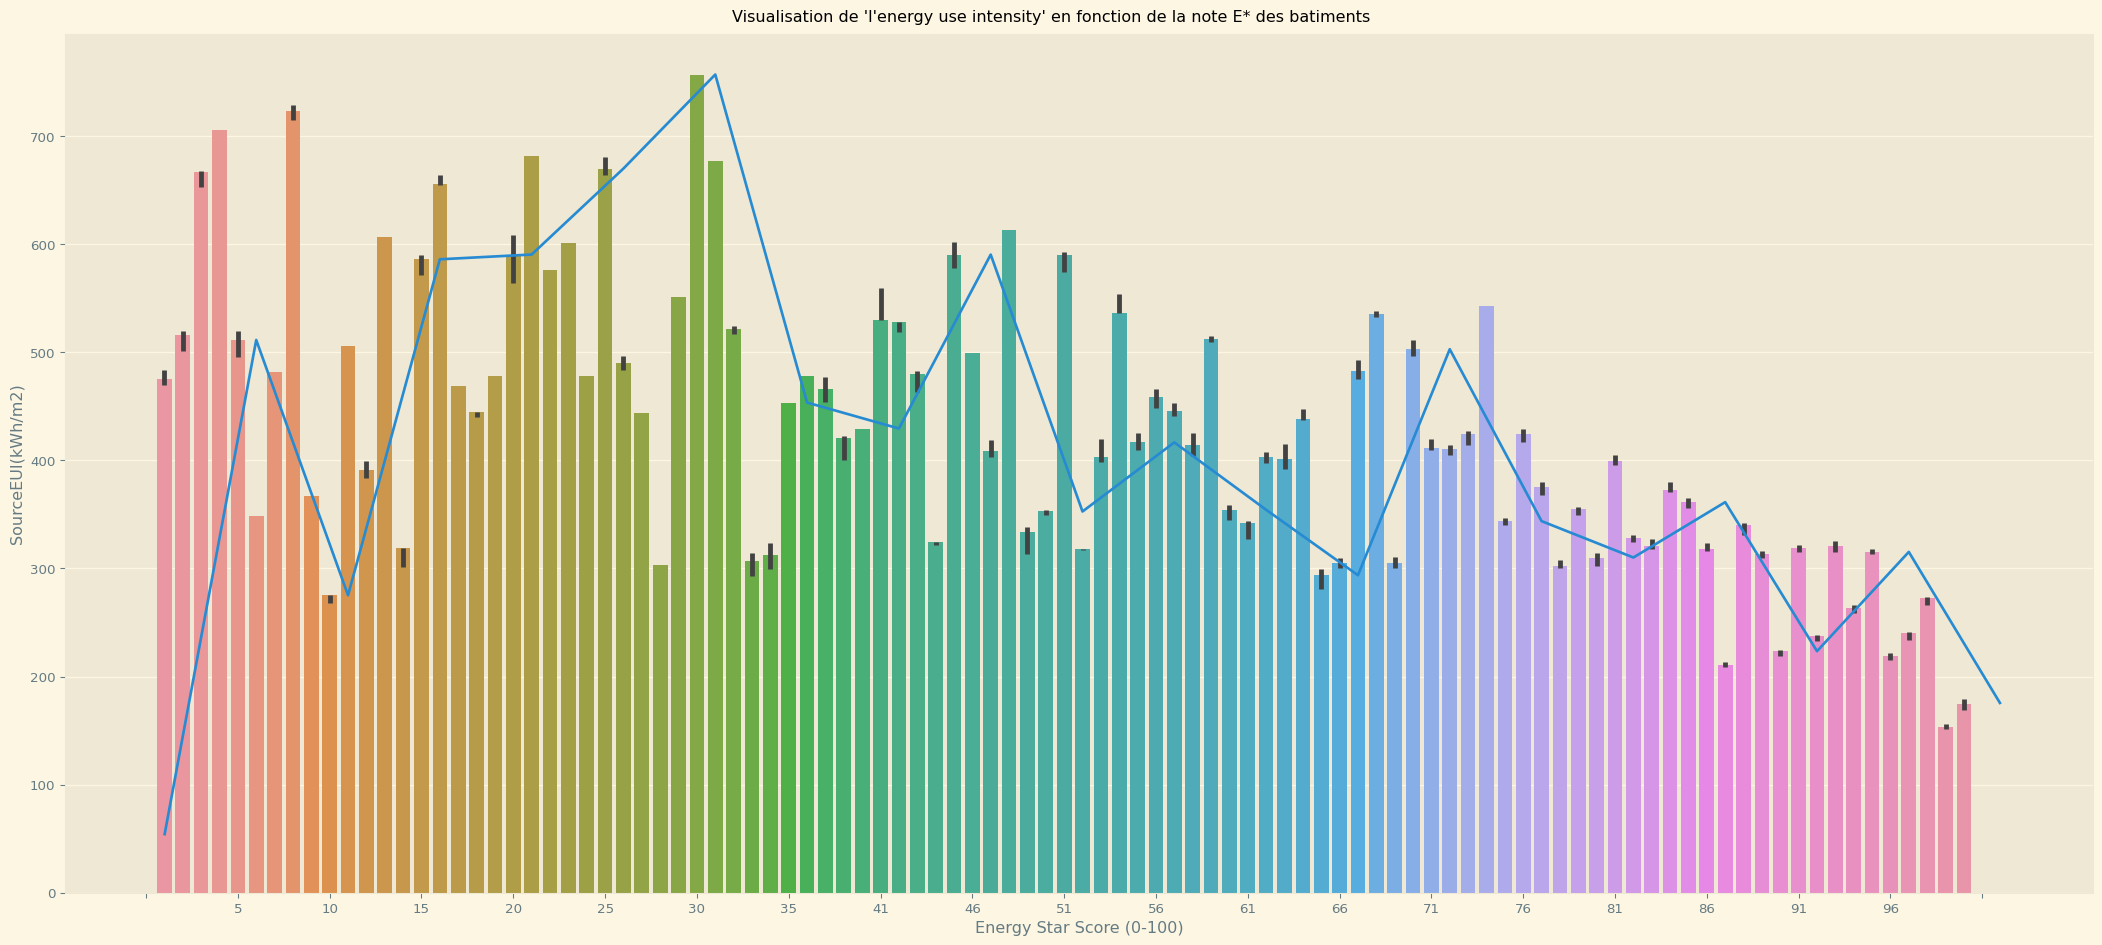

In [12]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x=rated["ENERGYSTARScore"].values.astype(int),
    y=rated["SourceEUI(kWh/m2)"].values.astype(float),
    ci=10
)

x_line = np.arange(0, 101, 5)

y_line = []

for x in x_line:
    ratings_x = rated[rated["ENERGYSTARScore"] == x]
    mean_x = ratings_x["SourceEUI(kWh/m2)"].mean(numeric_only=None)
    if pd.isna(mean_x):
        mean_x = rated["ENERGYSTARScore"].quantile(0.25).mean()
    y_line.append(mean_x)

ax1.plot(x_line, y_line)

###
# Titles/Lables
ax1.set_xticks(np.arange(-1, 101, 5))
ax1.set_ylabel("SourceEUI(kWh/m2)")
ax1.set_xlabel("Energy Star Score (0-100)")
fig.suptitle("Visualisation de 'l'energy use intensity' en fonction de la note E* des batiments")
#
###

fig.tight_layout()
plt.show()


#### Observation 
- On peut observer ici un lien clair entre le Score Energy Star (E*) et l'intensité d'utilisation énergétique (EUI). Le lien est logique dans ce cas : le site E* explique que, entre autres, l'utilisation d'énergie est un facteur.
- Le site internet d'E* fourni également une motivation pour l'obtention de cette note : un batiment est "Energy Star Certified" lorsque sa note est supérieure ou égale à 75 (ce qui peut expliquer le pic autour de cette note : les developpeurs immobiliers ont interèt à obtenir cette certification)

### 2.c : Paire 3 : Note Energy Star en fonction de l'intensité d'emissions de GES.

In [13]:
rated.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'LargestPropertyUseType', 'ENERGYSTARScore', 'Electricity(kWh)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'PropertyArea(SquareMetre)Total', 'PropertyArea(SquareMetre)Parking',
       'PropertyArea(SquareMetre)Building(s)',
       'LargestPropertyUseTypeArea(SquareMetre)', 'SourceEUI(kWh/m2)',
       'SourceEUIWN(kWh/m2)', 'SiteEnergyUse(kWh)', 'SiteEnergyUseWN(kWh)',
       'NaturalGas(kWh)'],
      dtype='object')

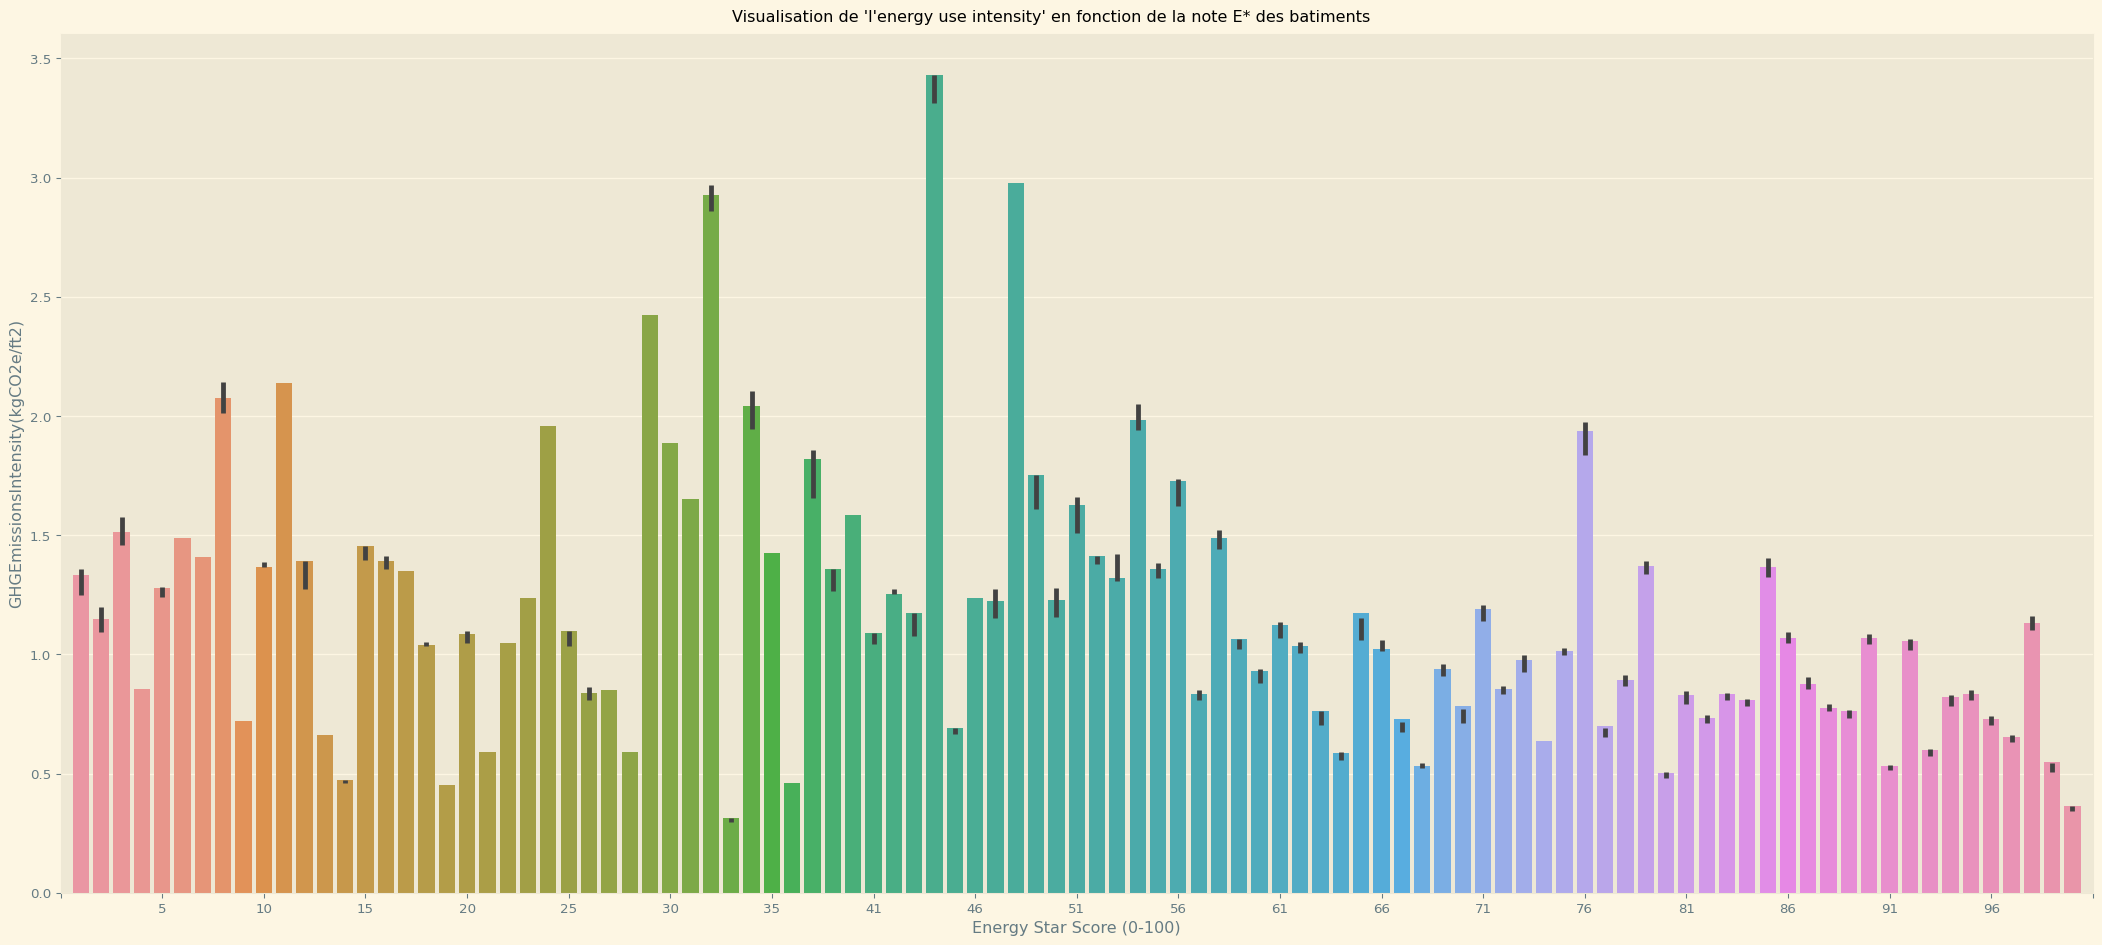

In [14]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x=rated["ENERGYSTARScore"].values.astype(int),
    y=rated["GHGEmissionsIntensity(kgCO2e/ft2)"].values.astype(float),
    ci=10
)

###
# Titles/Lables
ax1.set_xticks(np.arange(-1, 101, 5))
ax1.set_ylabel("GHGEmissionsIntensity(kgCO2e/ft2)")
ax1.set_xlabel("Energy Star Score (0-100)")
fig.suptitle("Visualisation de 'l'energy use intensity' en fonction de la note E* des batiments")
#
###

fig.tight_layout()
plt.show()


#### Observations :
- Les batiments les mieux notés ont une faible intensite d emission de GES, meme si cela ne semble pas etre systematique (note: 31 -> 56)
- Cela ne semble pas etre le seul facteur mais peu tout de meme distinguer une tendance

### 2.c Paire 4 : Rapport entre E* et année de construction :


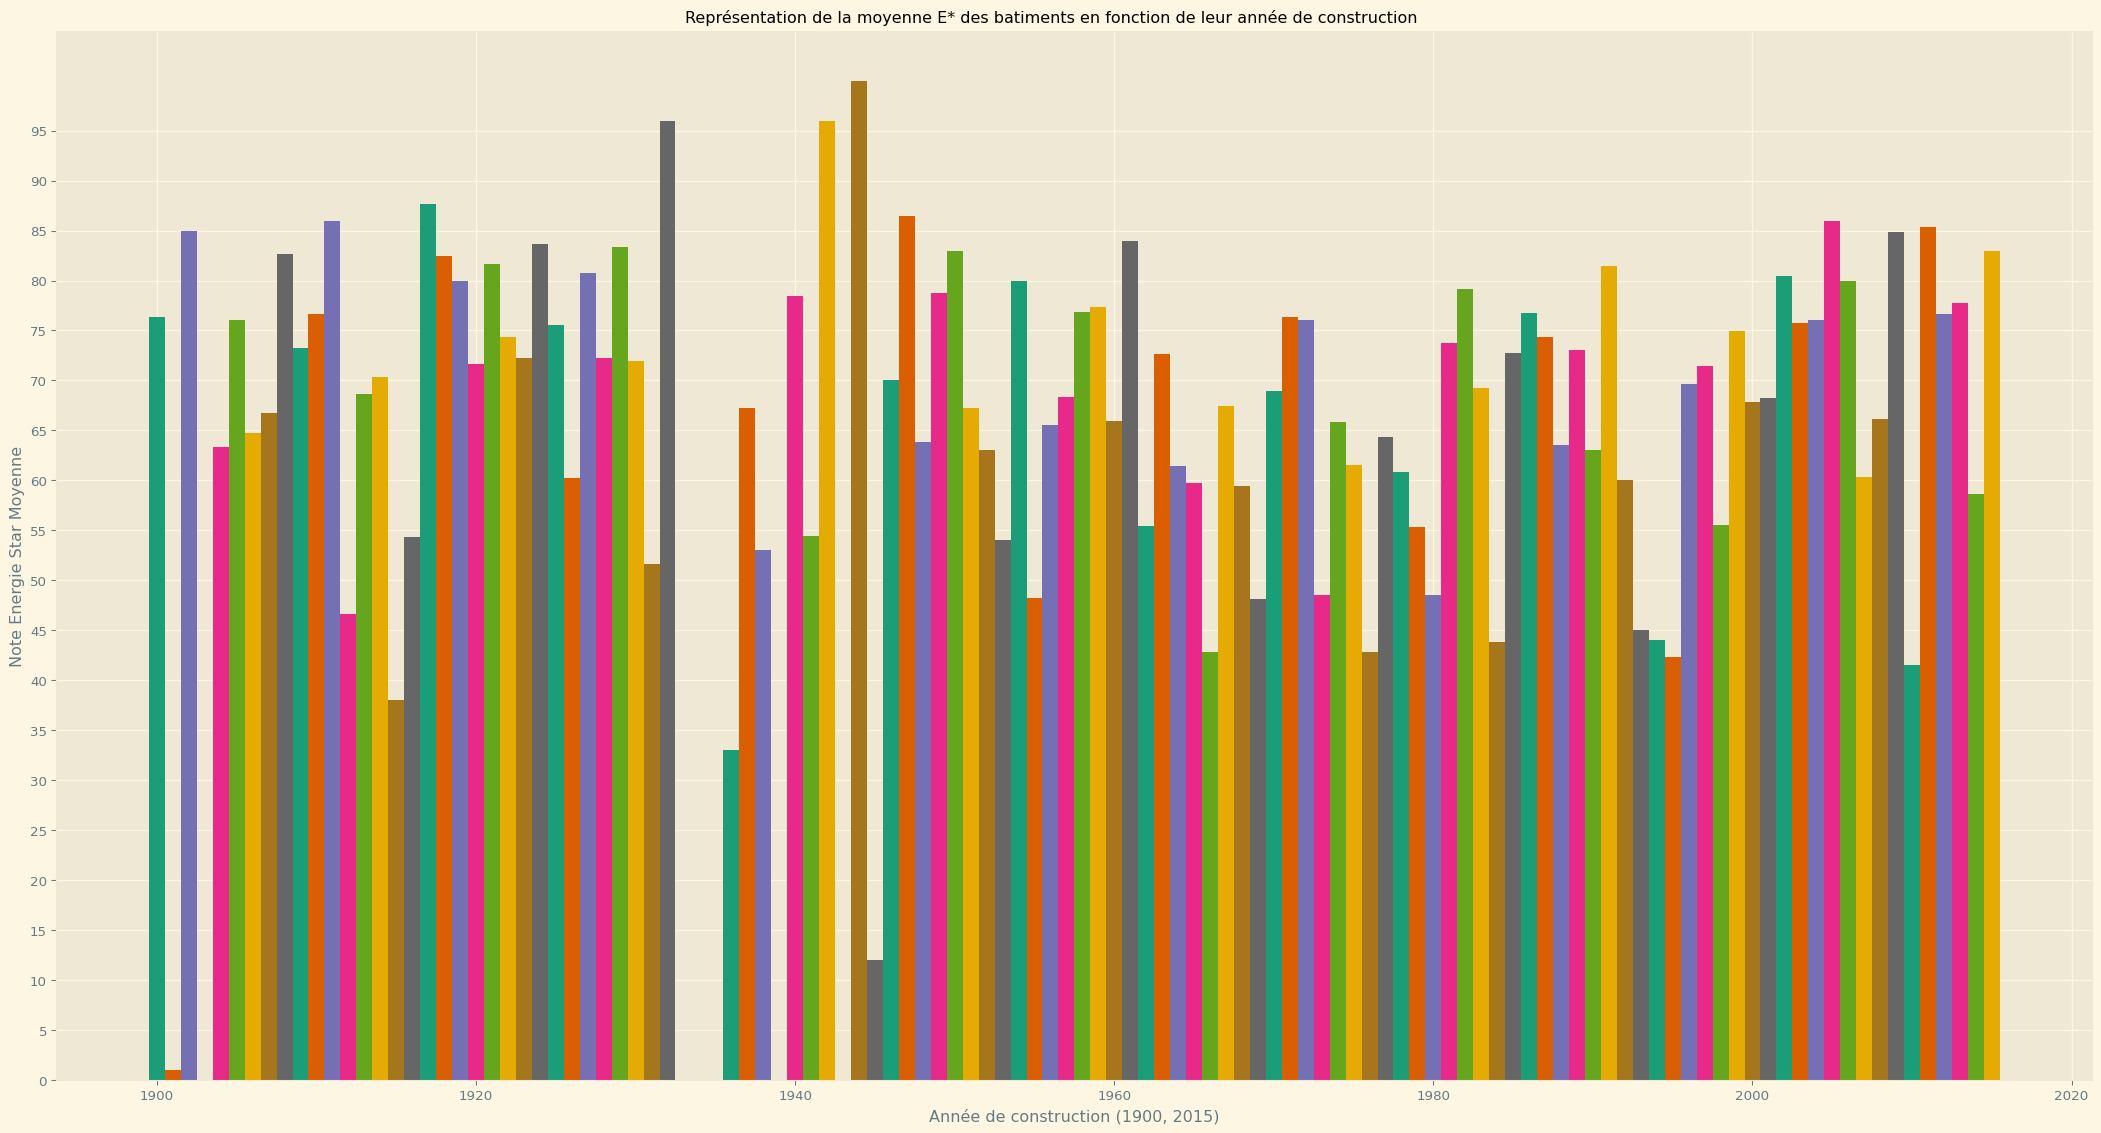

In [15]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

years_list = list(df_seattle[df_seattle["YearBuilt"].notna()]["YearBuilt"].values)
year_keys = []
for year in years_list:
    if year not in year_keys:
        year_keys.append(year)

year_keys.sort()

year_dict = dict.fromkeys(year_keys)

for key in year_dict.keys():
    temp = df_seattle[(df_seattle["YearBuilt"] == key) & (df_seattle["ENERGYSTARScore"].notna())]
    scores = [int(i) for i in temp["ENERGYSTARScore"]]
    try:
        mean = sum(scores) / len(scores)
        year_dict[key] = mean
    except ZeroDivisionError:
        year_dict[key] = 0

ax1.bar(
    x=list(year_dict.keys()),
    height=list(year_dict.values()),
    color=used_cmap.colors,
    width=1,
    )

###
# Titles/Lables
ax1.set_yticks(np.arange(0, 100, 5))
ax1.set_ylabel("Note Energie Star Moyenne")
ax1.set_xlabel("Année de construction (1900, 2015)")
fig.suptitle("Représentation de la moyenne E* des batiments en fonction de leur année de construction")
#
###

fig.tight_layout()
plt.show()


#### Observation :
- L'année de construction ne semble pas de lien clair avec la note E* - Cela peut venir, comme ecrit plus haut, de travaux de modernisation par exemple.

## 3 : Représentation Property Type/Utilisation Energie

<i>On cherche s'il existe des correllations entre les principaux types de batiments et leur note E*| emissions de GES | Intensite d utilisation energetique</i>

### 3.a Visualisation des categories principales

In [16]:
uniques = df_seattle["PrimaryPropertyType"].unique()
unique_ptype_dict = dict.fromkeys(uniques)
for unique in unique_ptype_dict.keys():
    unique_ptype_dict[unique] = len(df_seattle[df_seattle["PrimaryPropertyType"] == unique])

unique_ptype_dict


{'Hotel': 50,
 'K-12 School': 120,
 'Small- and Mid-Sized Office': 230,
 'Large Office': 73,
 'Retail Store': 64,
 'Residence Hall': 18,
 'Other': 7,
 'Warehouse': 140,
 'Worship Facility': 64,
 'Mixed Use Property': 17,
 'Distribution Center': 37,
 'Medical Office': 22,
 'Supermarket / Grocery Store': 4,
 'Refrigerated Warehouse': 5,
 'Senior Care Community': 11,
 'Hospital': 1,
 'Office': 3,
 'Non-Refrigerated Warehouse': 2}

#### Observations :
- SPS -> Seattle Public School
- K12 -> Shool -> from kindergarten to 12th grade
- Typos, doubles espaces etc.
- Pré groupement via généralisation
- La generalisation permettra de creer des categories plus inclusives tout en gardant les propriétes principales des batiments
- Necessité de clarification : Batiments types cités universitaires & campus comptent comme residentiels ?

In [17]:
correction_dict = {
    "Self-Storage Facility\n": "Self-Storage Facility",  # Possibly warehouse
    "Small- and Mid-Sized Office": "Small & Mid-Sized Office",
    "Restaurant\n": "Restaurant",
    "Distribution Center\n": "Supermarket & Grocery store",
    "Distribution Center": "Supermarket & Grocery store",
    "Supermarket/Grocery Store": "Supermarket & Grocery store",
    "Supermarket / Grocery Store": "Supermarket & Grocery store",
    "SPS-District K-12": "K-12 School",
    "Senior Care Community": "Small & Medium medical facility",  # Unsure
    "Laboratory": "Small & Medium medical facility",  # Unsure
    "Medical Office": "Small & Medium medical facility",  # Unsure
    "Small- and Mid-Sized Office": "Small & Mid-Sized Office",
    "Non-Refrigerated Warehouse": "Warehouse",
    "Residence Hall/Dormitory": "Residence Hall",
    "University": "College/University",
    "Retail Store": "Supermarket & Grocery store",
    "Self-Storage Facility": "Warehouse",  # Unsure
}

for key in correction_dict.keys():
    df_seattle["PrimaryPropertyType"].replace(to_replace=key, value=correction_dict[key], inplace=True)

print(df_seattle["PrimaryPropertyType"].value_counts())



Small & Mid-Sized Office           230
Warehouse                          142
K-12 School                        120
Supermarket & Grocery store        105
Large Office                        73
Worship Facility                    64
Hotel                               50
Small & Medium medical facility     33
Residence Hall                      18
Mixed Use Property                  17
Other                                7
Refrigerated Warehouse               5
Office                               3
Hospital                             1
Name: PrimaryPropertyType, dtype: int64


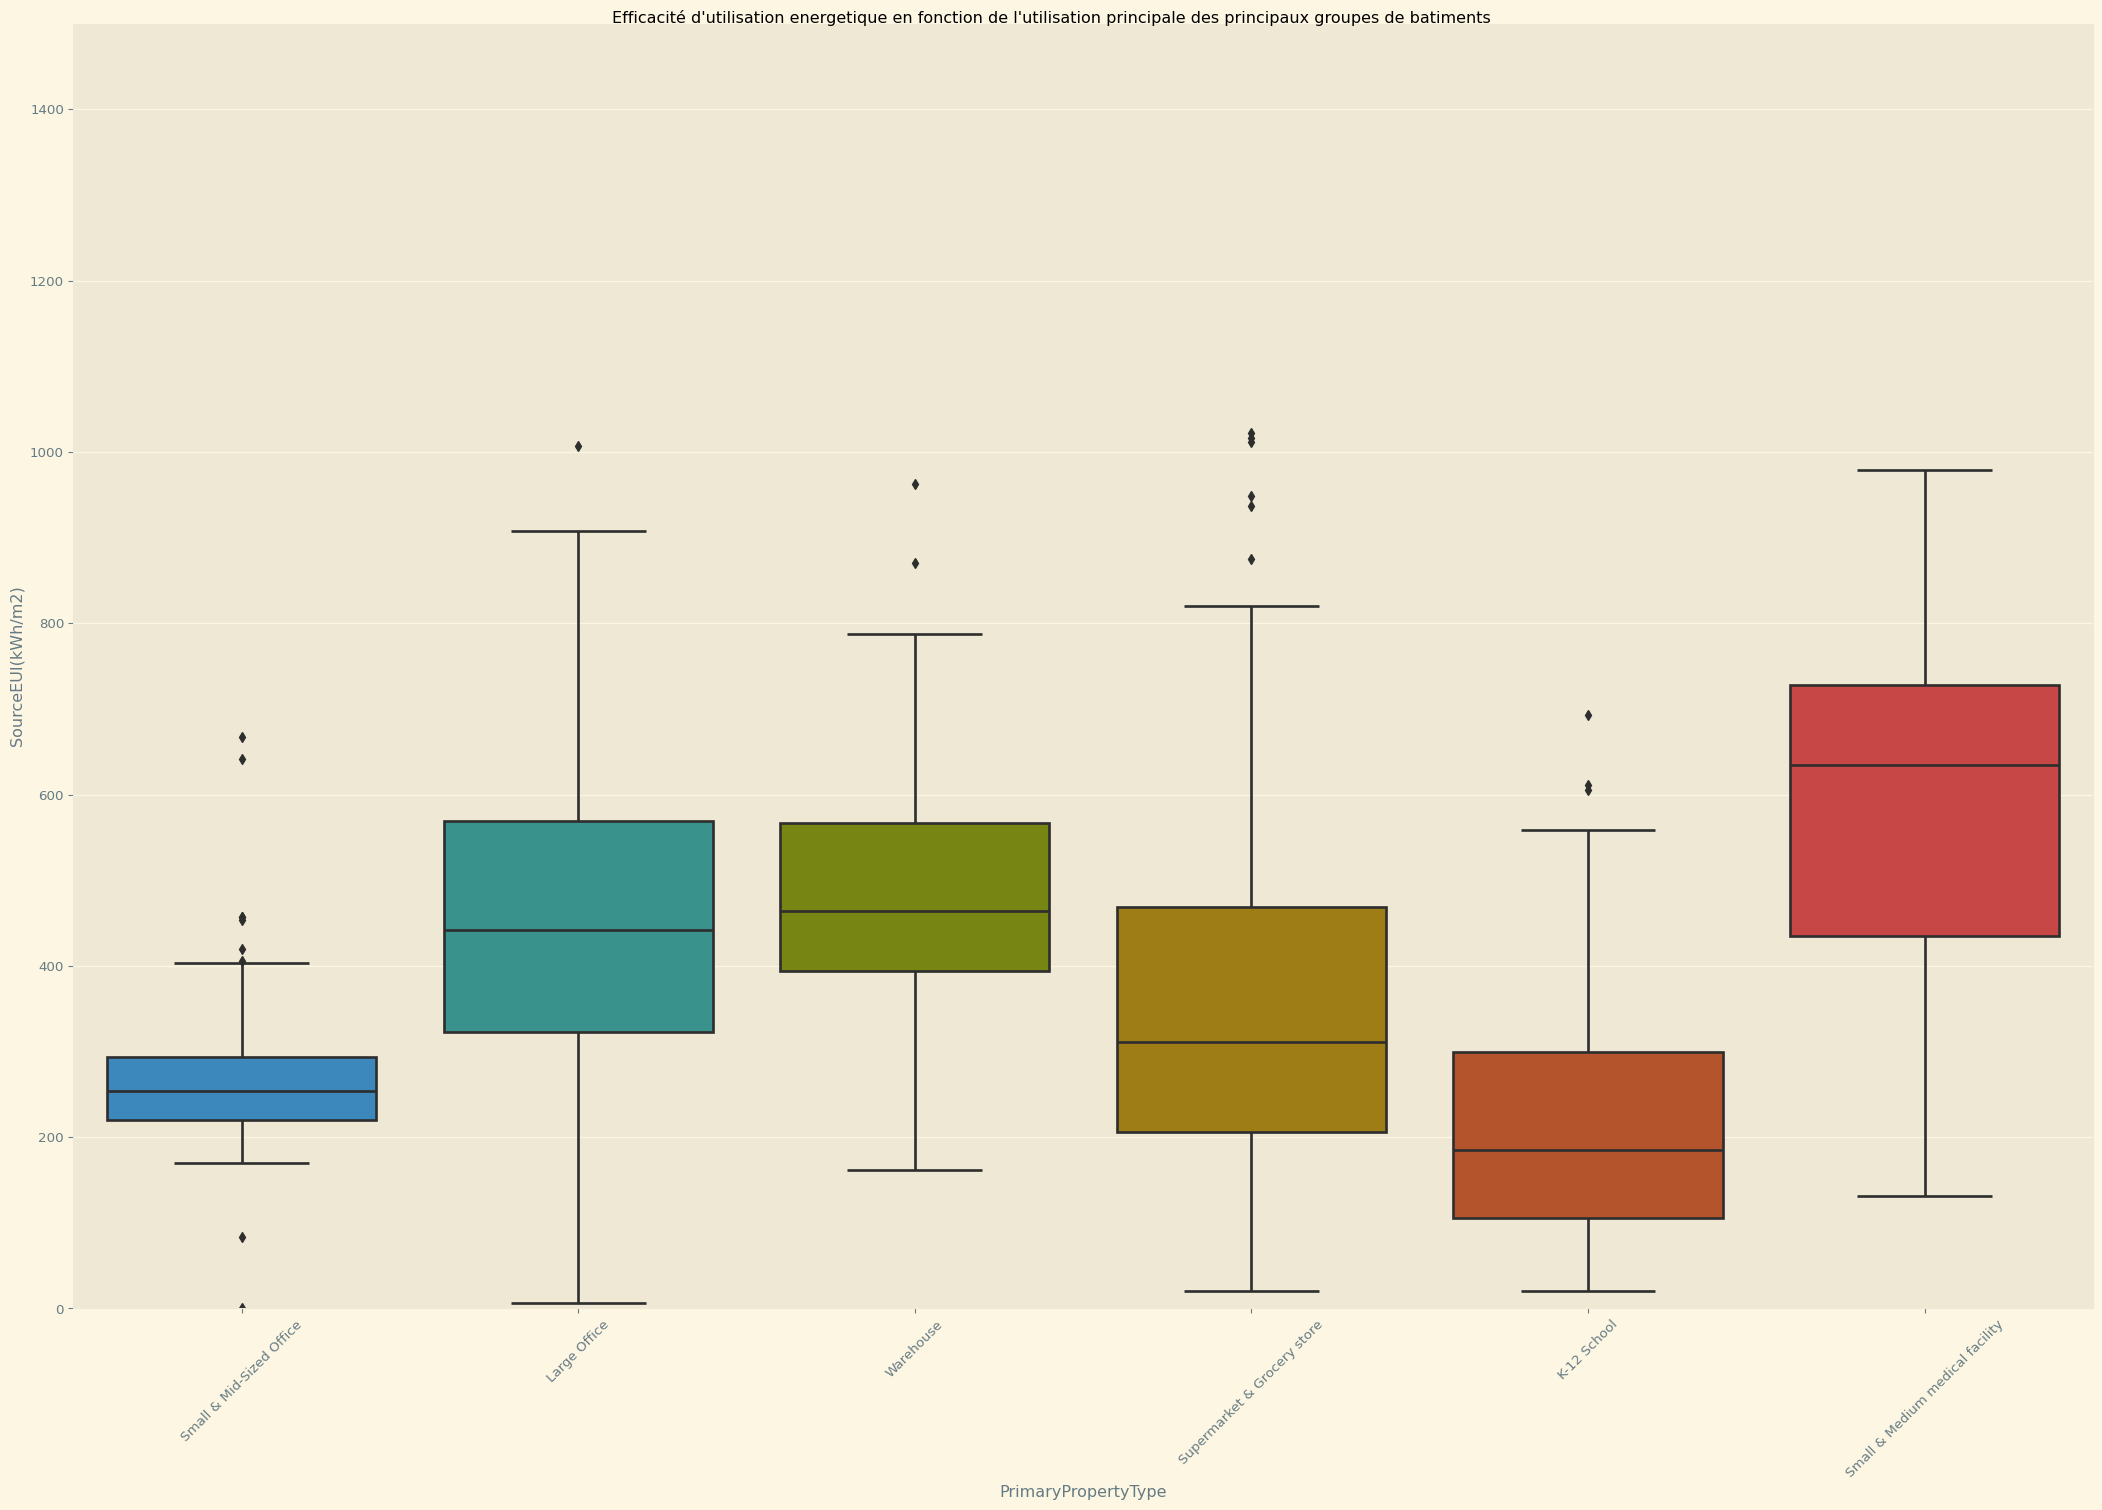

In [18]:
select_six = [
    "Small & Mid-Sized Office", "Large Office", "Warehouse", "Supermarket & Grocery store",
    "K-12 School", "Small & Medium medical facility",
]

# EUI , color code property type, sample based on smallest group size

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 16),
    dpi=pc_dpi,
)

data_ptype = df_seattle[df_seattle["PrimaryPropertyType"].isin(select_six)]

ax1 = sns.boxplot(
    x=data_ptype["PrimaryPropertyType"],
    y=data_ptype["SourceEUI(kWh/m2)"],
    data=data_ptype
)

###
# Titles/Lables
ax1.set_xticklabels(
    labels=select_six,
    rotation=45
    )
ax1.set_ylim(0, 1500)  # few outliers above
fig.suptitle("Efficacité d'utilisation energetique en fonction de l'utilisation principale des principaux groupes de batiments")

#
###

plt.tight_layout()
plt.show()


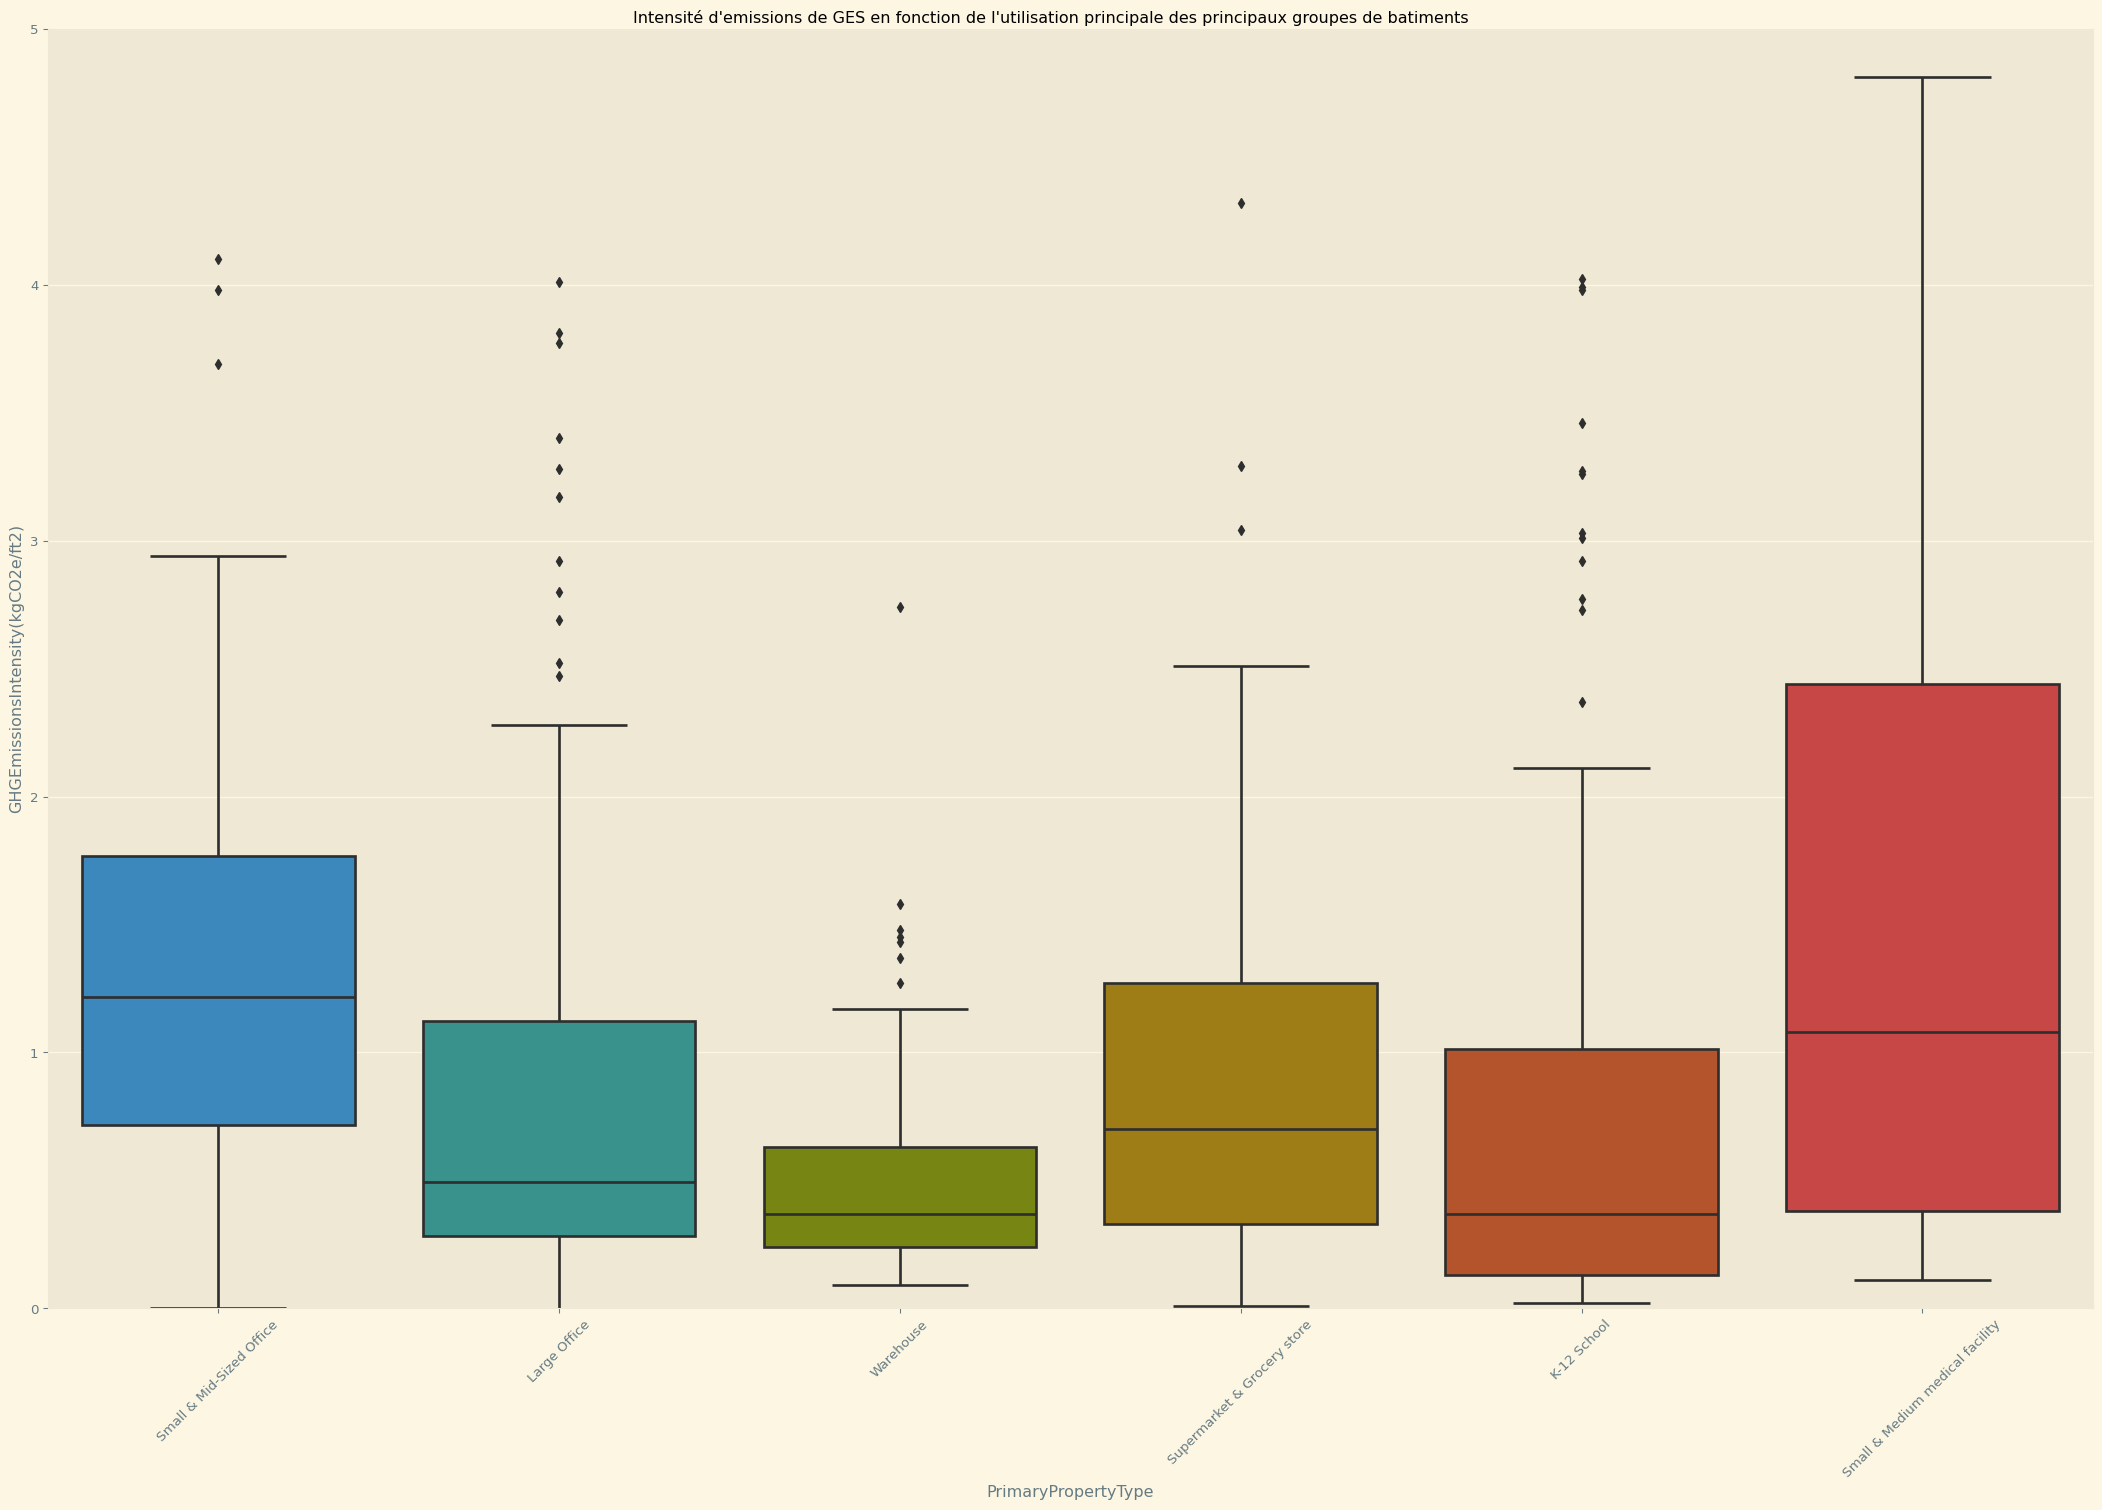

In [19]:
# GES, color code property type, sample based on smallest group size

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 16),
    dpi=pc_dpi,
)

data_ptype = df_seattle[df_seattle["PrimaryPropertyType"].isin(select_six)]

ax1 = sns.boxplot(
    x=data_ptype["PrimaryPropertyType"],
    y=data_ptype["GHGEmissionsIntensity(kgCO2e/ft2)"],
    data=data_ptype
)

###
# Titles/Lables
ax1.set_xticklabels(
    labels=select_six,
    rotation=45
    )
ax1.set_ylim(0, 5)  # few outliers above
fig.suptitle("Intensité d'emissions de GES en fonction de l'utilisation principale des principaux groupes de batiments")
#
###

plt.tight_layout()
plt.show()


#### Observations :
- On voit que dans les deux cas, la statistique étudiée semble avoir une grande importance sur la repartition de la statistique en question
- Il est possible de realiser deux ANOVAs pour vérifier ces hypotheses :

### ANOVAs :
- On definit alpha sur 0.05 | 5%
- On formulle les hypotheses nulles suivantes : 
  - Les differences observees entre les batiments etudies ne sont pas dus a leur types respectifs (a : pour ce qui est de l'utilisation energetique, b : pour ce qui est de leurs emissions de GES)
- Les criteres de l'ANOVA sont : 
  - 1. La normalité des résidus (test de shapiro sur les residus)
  - 2. Indépendance des échantillons (ce qui est, ici, le cas)
  - 3. Une variance homogène entre les échantillons (on utilisera le test de Bartlett)
- On cherche a invalider les deux hypotheses nulles (H0a et H0b)

In [20]:
alpha = 0.05
α = 0.05  # Double definition for unicode possible errors

anova_dict = dict.fromkeys(select_six)

# Dict w/ key value pair -> key = type, value = tuple, tuple[0] = SourceEUI(kWh/m2), tuple[1] = GHGEmissionsIntensity(kgCO2e/ft2)

for key in anova_dict.keys():
    anova_dict[key] = (
        data_ptype[data_ptype["PrimaryPropertyType"] == key]["SourceEUI(kWh/m2)"].values,
        data_ptype[data_ptype["PrimaryPropertyType"] == key]["GHGEmissionsIntensity(kgCO2e/ft2)"].values
    )

print(anova_dict.keys())


dict_keys(['Small & Mid-Sized Office', 'Large Office', 'Warehouse', 'Supermarket & Grocery store', 'K-12 School', 'Small & Medium medical facility'])


### Tests equal var 1 & 2

In [21]:
bartlett_eui = stats.bartlett(
    anova_dict["Small & Mid-Sized Office"][0],
    anova_dict["Large Office"][0],
    anova_dict["Warehouse"][0],
    anova_dict["Supermarket & Grocery store"][0],
    anova_dict["K-12 School"][0],
    anova_dict["Small & Medium medical facility"][0]
)

print(bartlett_eui)
print(bartlett_eui.pvalue > α)


BartlettResult(statistic=119.30428681833442, pvalue=4.406363753292183e-24)
False


In [22]:
bartlett_ghg = stats.bartlett(
    anova_dict["Small & Mid-Sized Office"][1],
    anova_dict["Large Office"][1],
    anova_dict["Warehouse"][1],
    anova_dict["Supermarket & Grocery store"][1],
    anova_dict["K-12 School"][1],
    anova_dict["Small & Medium medical facility"][1]
)

print(bartlett_ghg)
print(bartlett_ghg.pvalue > α)


BartlettResult(statistic=70.62551606006012, pvalue=7.593449476153952e-14)
False


#### On ne peut pas proceder a une ANOVA dans les deux cas

Le test de Kruskal-Wallis peut etre utilisé par exemple, mais dans ce cas la, on voit clairement que la variable "PrimaryPropertyType" a une influence sur l EUI et intensite de GES. Cette variable est par consequent pertinente pour la creation d'un modele determinant ces deux facteurs

<hr>

## Export 1 :
- Export contenant les variables pré-ACP pour pouvoir tenter de predire les utilisations energetiques et les emissions de GES
- Ces variables seront prises en compte dans l'ACP effectuee plus bas, il convient donc d'exporter un premier dataset contenant les variables avant reduction de dimension
- Pour eviter de biaiser le modele, on excluera les variables permettant de calculer directement l intensite d emission de GES et d utilisation energetique, a savoir :
  - SourceEUIWN, PropertyArea(SquareMetre)Total', 'PropertyArea(SquareMetre)Parking', 'PropertyArea(SquareMetre)Building(s)', LargestPropertyUseTypeArea(SquareMetre)
    - --> Ces variables permettent de calculer manuellement les valeurs cibles
  - Les valeurs cibles seront : SourceEUI(kWh/m2) & GHGEmissionsIntensity(kgCO2e/ft2)
- Elimination des redondances : PrimaryPropertyType & BuildingType & LargestPropertyUseType (Building type est moins divers et sera exclu)
- PropertyName n est pas utile
- On utilise One Hot Encoder pour les variables categorielles comme Primary Property Type et Neighborhood

<hr>

In [23]:
columns_keep = [
        "OSEBuildingID", "PrimaryPropertyType", "Neighborhood", "YearBuilt",
        "NumberofBuildings", "NumberofFloors", "ENERGYSTARScore", "Electricity(kWh)",
        "GHGEmissions(MetricTonsCO2e)", "GHGEmissionsIntensity(kgCO2e/ft2)",
        "SourceEUI(kWh/m2)", "SiteEnergyUse(kWh)", "SiteEnergyUseWN(kWh)", "NaturalGas(kWh)"
        ]

df_export_one = df_seattle[columns_keep]


In [24]:
## Scaling : 

scale_ignore_one = [
    "OSEBuildingID", "PrimaryPropertyType", "Neighborhood", "YearBuilt",
    "NumberofBuildings", "NumberofFloors", "ENERGYSTARScore",  # Discrete & Categorical vars ignored
    ]

df_export_one = scale_df(df_export_one, constant_col=scale_ignore_one)


In [25]:
df_export_one["PrimaryPropertyType"].value_counts()

# |v| No Conflict

Small & Mid-Sized Office           230
Warehouse                          142
K-12 School                        120
Supermarket & Grocery store        105
Large Office                        73
Worship Facility                    64
Hotel                               50
Small & Medium medical facility     33
Residence Hall                      18
Mixed Use Property                  17
Other                                7
Refrigerated Warehouse               5
Office                               3
Hospital                             1
Name: PrimaryPropertyType, dtype: int64

In [26]:
# Neighborhood

df_export_one["Neighborhood"].value_counts()

#|v| Few cols are similar but lowercase/uppercase conflict -> applying str.upper to all


GREATER DUWAMISH         197
DOWNTOWN                 157
LAKE UNION                83
MAGNOLIA / QUEEN ANNE     77
NORTHEAST                 69
EAST                      54
NORTHWEST                 46
SOUTHEAST                 33
BALLARD                   32
NORTH                     31
DELRIDGE                  27
CENTRAL                   24
SOUTHWEST                 22
Northwest                  5
Ballard                    4
North                      3
Delridge                   2
Central                    2
Name: Neighborhood, dtype: int64

In [27]:
df_export_one["Neighborhood"] = df_export_one["Neighborhood"].apply(str.upper)

# Using OneHotEncoder from sklearn for Neighborhood & PrimaryPropertyType
# Transforming and applying with prefix

ohe_nbhood = preprocessing.OneHotEncoder()

transformed = ohe_nbhood.fit_transform(df_export_one[["Neighborhood"]])

df_export_one[ohe_nbhood.categories_[0]] = transformed.toarray()

cols_nbhood = list(ohe_nbhood.categories_[0])

rename_hood = dict.fromkeys(cols_nbhood)

for key in rename_hood.keys():
    rename_hood[key] = f"ohe_nbhood_{key}"

df_export_one.rename(columns=rename_hood, inplace=True)
ohe_ptype = preprocessing.OneHotEncoder()

transformed = ohe_ptype.fit_transform(df_export_one[["PrimaryPropertyType"]])

df_export_one[ohe_ptype.categories_[0]] = transformed.toarray()

cols_ptype = list(ohe_ptype.categories_[0])

rename_ptype = dict.fromkeys(cols_ptype)

for key in rename_ptype.keys():
    rename_ptype[key] = f"ohe_ptype_{key}"

df_export_one.rename(columns=rename_ptype, inplace=True)

df_export_one.drop(columns=["Neighborhood", "PrimaryPropertyType"], inplace=True)  # Removing encoded cols

# Using OHEBuildingID as index removes one column while preserving unique building id

df_export_one.set_index("OSEBuildingID", inplace=True)


In [28]:
df_export_one.to_csv("./data/seattle_predict_ghg_eui.csv", sep=",")


### 4. Reduction de dimension pour alléger le dataset en vue d'exportation pour modeles predictifs

Pour rendre lisible les modelisations predictives, il est necessaire de reduire la dimension du dataset pour que le moins d'attributs possibles puissent fournir le maximum d'information.
- Dans un premier temps, il est envisageable de realiser une reduction de dimension sur les variables, si possible via ACP (si cette approche se révèle trop peu precise, les methodes non lineaires telles que T-SNE ou UMAP sont envisageables)
- Dans un second temps, l'étude ci dessus a pu montrer que les batiments appartenant aux memes "categories" partagent des caracteristiques et des trends qui peuvent etre exploitables pour traiter les objets en tant que clusters plutot que separement (K-Means)

#### 4.a : Elimination des variables inutiles la modelisation

- Certaines variables sont inutiles a la modelisation. Si elles permettent de mieux comprendre la note E*, un grand nombre de variable sera inutile a la creation de modeles
- Dans un premier temps : filtrage manuel des features
- Creation d'une copie du df_seattle - il regroupe des features utiles a d'autres analyses (df_export)
- On peut "Eliminer" la variable `OSEBuildingID` en la considerant comme l'index du dataset (unique id)

In [29]:
manual_suppression_list = [
    "PropertyArea(SquareMetre)Parking", "PropertyArea(SquareMetre)Building(s)", # row 1 & 2.1 = duplicates/parts of PropertyAreaTotal
    "LargestPropertyUseTypeArea(SquareMetre)", "PropertyName", "BuildingType",
    "NumberofBuildings", "NumberofFloors", "LargestPropertyUseType", #  Duplicate or ptype (+|-)
    ]

df_seattle.drop(columns=manual_suppression_list, inplace=True, errors="ignore")

# Setting OSEBuildingID as index aswl
df_seattle.set_index("OSEBuildingID", inplace=True)

df_seattle.columns


Index(['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'ENERGYSTARScore',
       'Electricity(kWh)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'PropertyArea(SquareMetre)Total',
       'SourceEUI(kWh/m2)', 'SourceEUIWN(kWh/m2)', 'SiteEnergyUse(kWh)',
       'SiteEnergyUseWN(kWh)', 'NaturalGas(kWh)'],
      dtype='object')

#### 4.b : Realisation d'une ACP sur les colonnes restantes

In [30]:
ignore_pca = [
    "Neighborhood", "PrimaryPropertyType", # Usable features, using OneHotEncoder @ export
    "ENERGYSTARScore" # Baseline
]

columns_pca = [col for col in df_seattle.columns if col not in ignore_pca]

print(columns_pca)


['YearBuilt', 'Electricity(kWh)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'PropertyArea(SquareMetre)Total', 'SourceEUI(kWh/m2)', 'SourceEUIWN(kWh/m2)', 'SiteEnergyUse(kWh)', 'SiteEnergyUseWN(kWh)', 'NaturalGas(kWh)']


In [31]:

data_pca = df_seattle[columns_pca]

data_pca = data_pca.astype(float)  # All values are forced converted to float, as the columns above (columns_pca) are all numeric

data_pca = data_pca.fillna(data_pca.mean())

X = data_pca.values
names = df_seattle.index
features = columns_pca

scaled_data = preprocessing.scale(data_pca)
pca = PCA(n_components=len(columns_pca))
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
percentage_variation = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

pcs = pca.components_


##### 4.b.1 : Eboulis des valeurs propres | Scree plot :

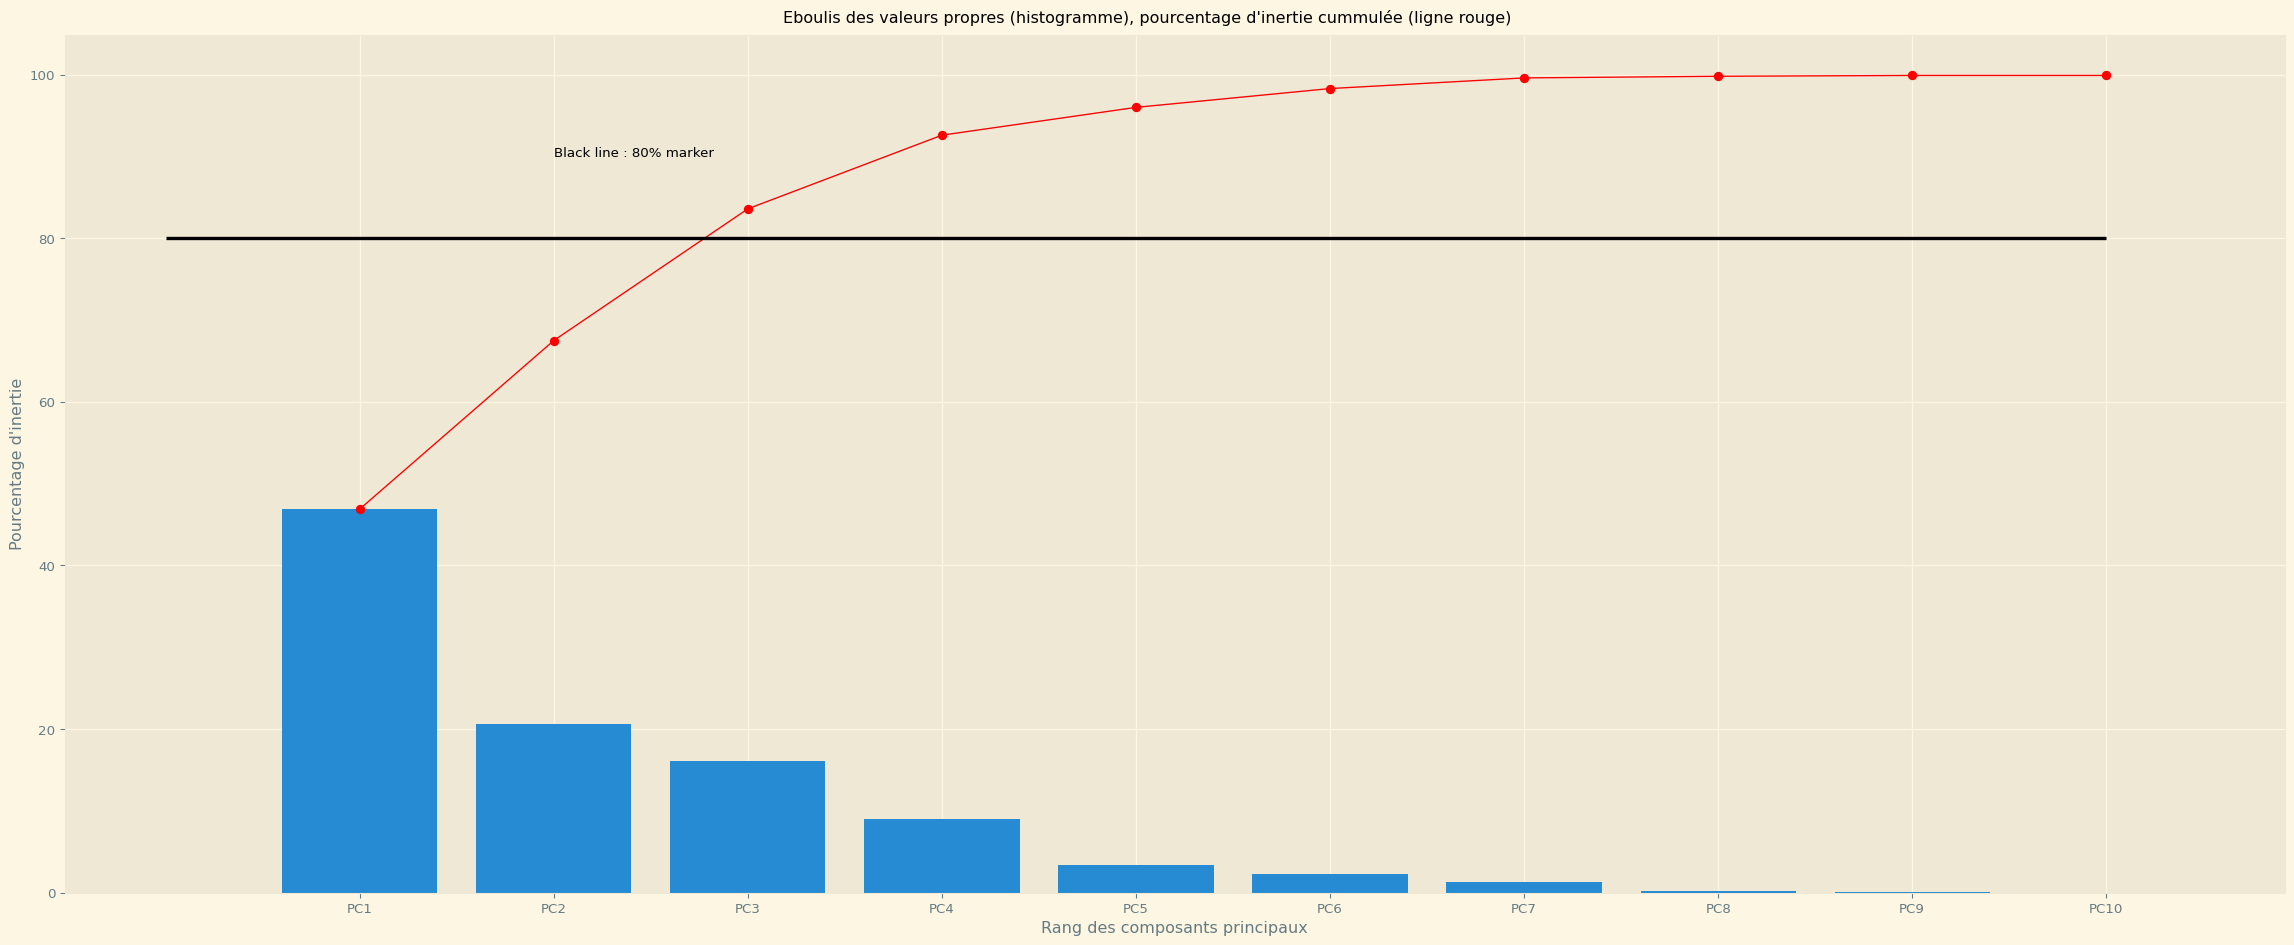

In [32]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(24, 10),
    dpi=pc_dpi,
)

x_bars = np.arange(1, len(percentage_variation) + 1, 1)

cummulative_percentage = np.cumsum(percentage_variation)

ax1.bar(x_bars, height=percentage_variation)  # Inertia Scree

###
# Titles/Lables
labels = ["PC" + str(c) for c in range (1, len(percentage_variation) + 1)]
ax1.set_xticks(range(1, len(labels) + 1, 1))
ax1.set_xticklabels(labels)
ax1.set_xlabel("Rang des composants principaux")
ax1.set_ylabel("Pourcentage d'inertie")
fig.suptitle("Eboulis des valeurs propres (histogramme), pourcentage d'inertie cummulée (ligne rouge)")
ax1.text(2, 90, 'Black line : 80% marker')
#
###

ax1.plot(ax1.get_xticks(), cummulative_percentage, marker="o", color="r", linewidth=1)  # Cumulative Inertia
ax1.plot(np.arange(0, len(cummulative_percentage) + 1, 1), [80 for _ in range(0, len(cummulative_percentage) + 1)], color="0", linewidth=2.5)
fig.tight_layout()

plt.show()


##### Observations : 
- PC1 -> PC3 regroupent 80+% de l'intertie totale, on peut également inclure PC4 si necessaire
- Etude des corrélations des Principaux Composants

##### 4.b.2 : Cercles de corrélation et dataframe details :

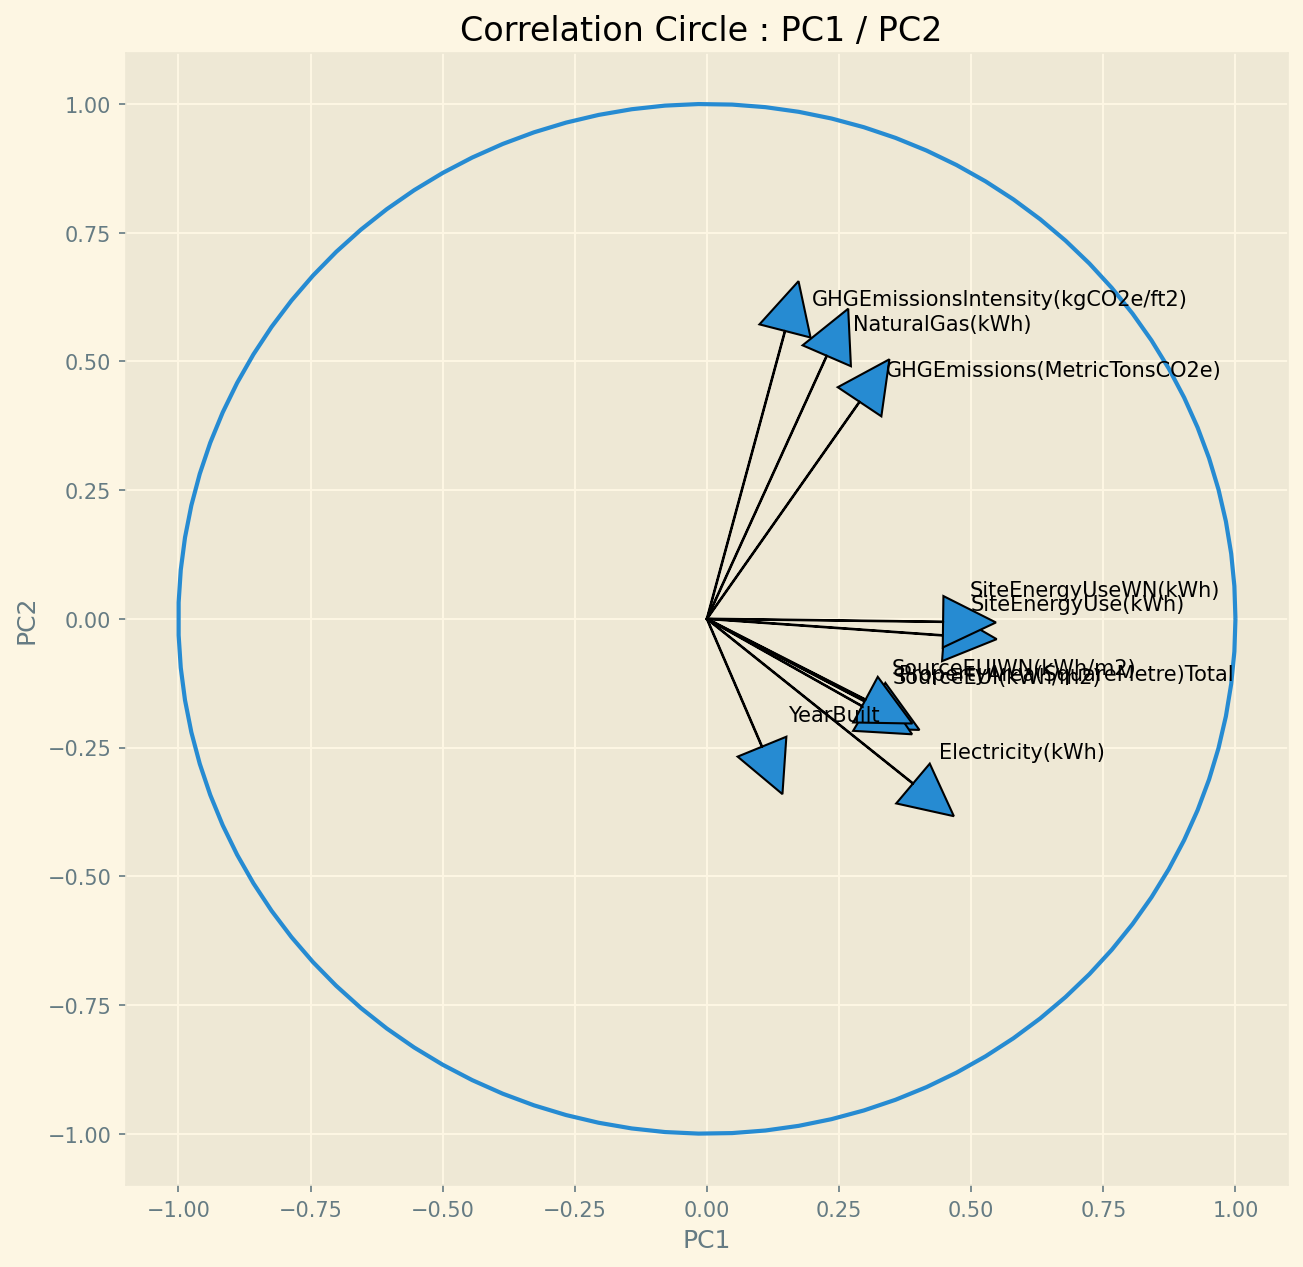

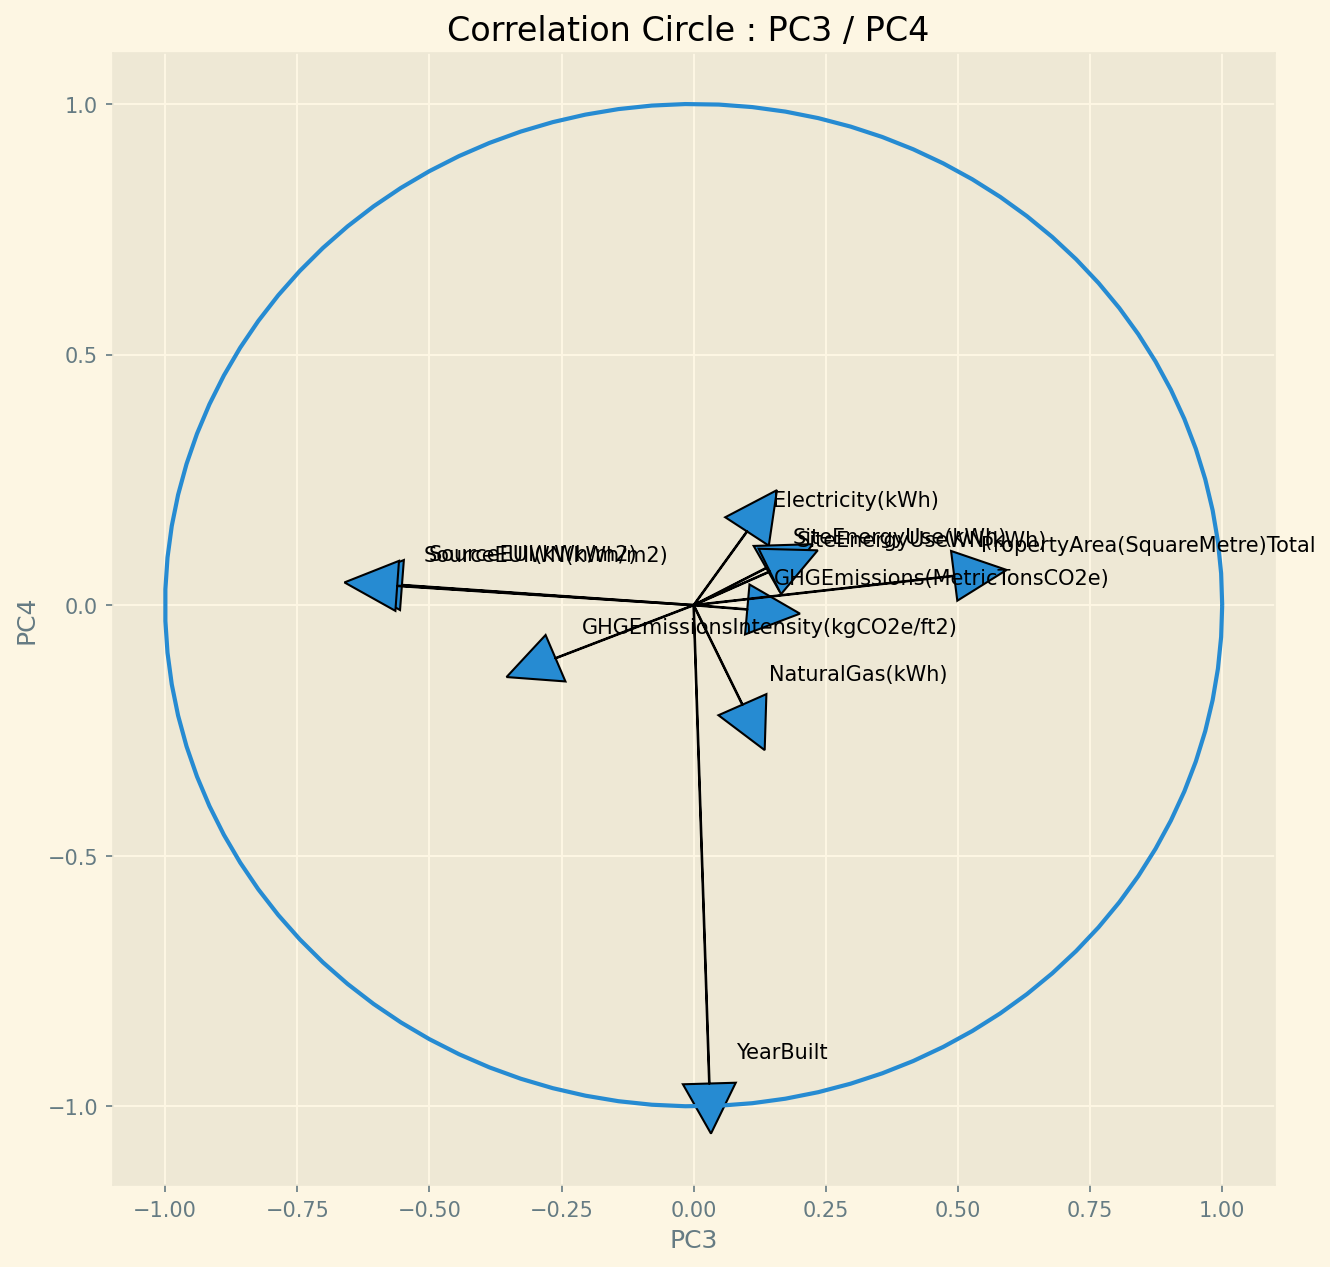

In [33]:
pc_couples = [(0, 1), (2, 3)]

for couple in pc_couples:
    display_circles(pca=pca, pca_cols=columns_pca, couple_pc=couple)


In [34]:
pca_explained_df = show_contribution(pca=pca, columns_pca=columns_pca, lim_pc=4)

pca_explained_df


,PC1,PC2,PC3,PC4
YearBuilt,0.104223,-0.248316,0.029649,-0.954525
Electricity(kWh),0.389923,-0.319903,0.100972,0.147067
GHGEmissions(MetricTonsCO2e),0.288804,0.421606,0.101438,-0.008558
GHGEmissionsIntensity(kgCO2e/ft2),0.147760,0.559182,-0.261362,-0.105907
PropertyArea(SquareMetre)Total,0.313987,-0.168490,0.492904,0.058490
SourceEUI(kWh/m2),0.301655,-0.174251,-0.551919,0.040120
SourceEUIWN(kWh/m2),0.300089,-0.156977,-0.560906,0.038494
SiteEnergyUse(kWh),0.448471,-0.032296,0.137320,0.074152
SiteEnergyUseWN(kWh),0.446842,-0.005782,0.144126,0.067182
NaturalGas(kWh),0.226769,0.510974,0.092258,-0.198591


##### 4.b.3 Details des coefficients de correlation des composants principaux
- On cherche a exprimer les valeurs telles que , pour f1 --> fn , PC = *a x f1 + b x f2 + ... + m x fn*
- Utilisation des valeurs absolues

In [35]:
pc_one = pca_explained_df["PC1"]
pc_one.sort_values(ascending=False)


contribution                         46.900000
SiteEnergyUse(kWh)                    0.448471
SiteEnergyUseWN(kWh)                  0.446842
Electricity(kWh)                      0.389923
PropertyArea(SquareMetre)Total        0.313987
SourceEUI(kWh/m2)                     0.301655
SourceEUIWN(kWh/m2)                   0.300089
GHGEmissions(MetricTonsCO2e)          0.288804
NaturalGas(kWh)                       0.226769
GHGEmissionsIntensity(kgCO2e/ft2)     0.147760
YearBuilt                             0.104223
Name: PC1, dtype: float64

In [36]:
pc_two = pca_explained_df["PC2"]
print(pc_two, "\n")

print("##############################################")

pc_two.abs().sort_values(ascending=False)


YearBuilt                            -0.248316
Electricity(kWh)                     -0.319903
GHGEmissions(MetricTonsCO2e)          0.421606
GHGEmissionsIntensity(kgCO2e/ft2)     0.559182
PropertyArea(SquareMetre)Total       -0.168490
SourceEUI(kWh/m2)                    -0.174251
SourceEUIWN(kWh/m2)                  -0.156977
SiteEnergyUse(kWh)                   -0.032296
SiteEnergyUseWN(kWh)                 -0.005782
NaturalGas(kWh)                       0.510974
contribution                         20.600000
Name: PC2, dtype: float64 

##############################################


contribution                         20.600000
GHGEmissionsIntensity(kgCO2e/ft2)     0.559182
NaturalGas(kWh)                       0.510974
GHGEmissions(MetricTonsCO2e)          0.421606
Electricity(kWh)                      0.319903
YearBuilt                             0.248316
SourceEUI(kWh/m2)                     0.174251
PropertyArea(SquareMetre)Total        0.168490
SourceEUIWN(kWh/m2)                   0.156977
SiteEnergyUse(kWh)                    0.032296
SiteEnergyUseWN(kWh)                  0.005782
Name: PC2, dtype: float64

In [37]:
pc_three = pca_explained_df["PC3"]
print(pc_three, "\n")

print("##############################################")

pc_three.abs().sort_values(ascending=False)


YearBuilt                             0.029649
Electricity(kWh)                      0.100972
GHGEmissions(MetricTonsCO2e)          0.101438
GHGEmissionsIntensity(kgCO2e/ft2)    -0.261362
PropertyArea(SquareMetre)Total        0.492904
SourceEUI(kWh/m2)                    -0.551919
SourceEUIWN(kWh/m2)                  -0.560906
SiteEnergyUse(kWh)                    0.137320
SiteEnergyUseWN(kWh)                  0.144126
NaturalGas(kWh)                       0.092258
contribution                         16.100000
Name: PC3, dtype: float64 

##############################################


contribution                         16.100000
SourceEUIWN(kWh/m2)                   0.560906
SourceEUI(kWh/m2)                     0.551919
PropertyArea(SquareMetre)Total        0.492904
GHGEmissionsIntensity(kgCO2e/ft2)     0.261362
SiteEnergyUseWN(kWh)                  0.144126
SiteEnergyUse(kWh)                    0.137320
GHGEmissions(MetricTonsCO2e)          0.101438
Electricity(kWh)                      0.100972
NaturalGas(kWh)                       0.092258
YearBuilt                             0.029649
Name: PC3, dtype: float64

In [38]:
pc_four = pca_explained_df["PC4"]
print(pc_four, "\n")

print("##############################################")

pc_four.abs().sort_values(ascending=False)


YearBuilt                           -0.954525
Electricity(kWh)                     0.147067
GHGEmissions(MetricTonsCO2e)        -0.008558
GHGEmissionsIntensity(kgCO2e/ft2)   -0.105907
PropertyArea(SquareMetre)Total       0.058490
SourceEUI(kWh/m2)                    0.040120
SourceEUIWN(kWh/m2)                  0.038494
SiteEnergyUse(kWh)                   0.074152
SiteEnergyUseWN(kWh)                 0.067182
NaturalGas(kWh)                     -0.198591
contribution                         9.000000
Name: PC4, dtype: float64 

##############################################


contribution                         9.000000
YearBuilt                            0.954525
NaturalGas(kWh)                      0.198591
Electricity(kWh)                     0.147067
GHGEmissionsIntensity(kgCO2e/ft2)    0.105907
SiteEnergyUse(kWh)                   0.074152
SiteEnergyUseWN(kWh)                 0.067182
PropertyArea(SquareMetre)Total       0.058490
SourceEUI(kWh/m2)                    0.040120
SourceEUIWN(kWh/m2)                  0.038494
GHGEmissions(MetricTonsCO2e)         0.008558
Name: PC4, dtype: float64

#### ACP : 

- PC1 : <b>46.9%</b> Explained Variance, Majoritairement composé de l'utilisation electrique et l'efficacité (Consommation/Metre Carré) et des composants de ces statistiques :
  - SiteEnergyUse(kWh)                    0.448471
  - SiteEnergyUseWN(kWh)                  0.446842
  - Electricity(kWh)                      0.389923
  - PropertyArea(SquareMetre)Total        0.313987
  - SourceEUI(kWh/m2)                     0.301655
  - SourceEUIWN(kWh/m2)                   0.300089
<hr>

- PC2 : <b>20.6%</b> Explained Variance, Plus gros coefficients liés à l'émission de pollution, anticorrélé avec l'utilisation electrique : 
  - GHGEmissionsIntensity(kgCO2e/ft2)     0.559182
  - NaturalGas(kWh)                       0.510974
  - GHGEmissions(MetricTonsCO2e)          0.421606  --> Plus polluant que l'electricité
  - Electricity(kWh)                     -0.319903

<hr>

- PC3 : <b>16.1%</b> Explained Variance, très sembable à PC1 (valeurs absolues)

<hr>

- PC4 : <b>9%</b> Explained Variance, pratiquement entierement basé sur l'age des batiments

<hr>

Un modele predictif utilisant comme variables principales PC1 (utilisation electrique) et PC2 (Pollution 'directe'), avec pour baseline l'E* peut être une piste interessante.


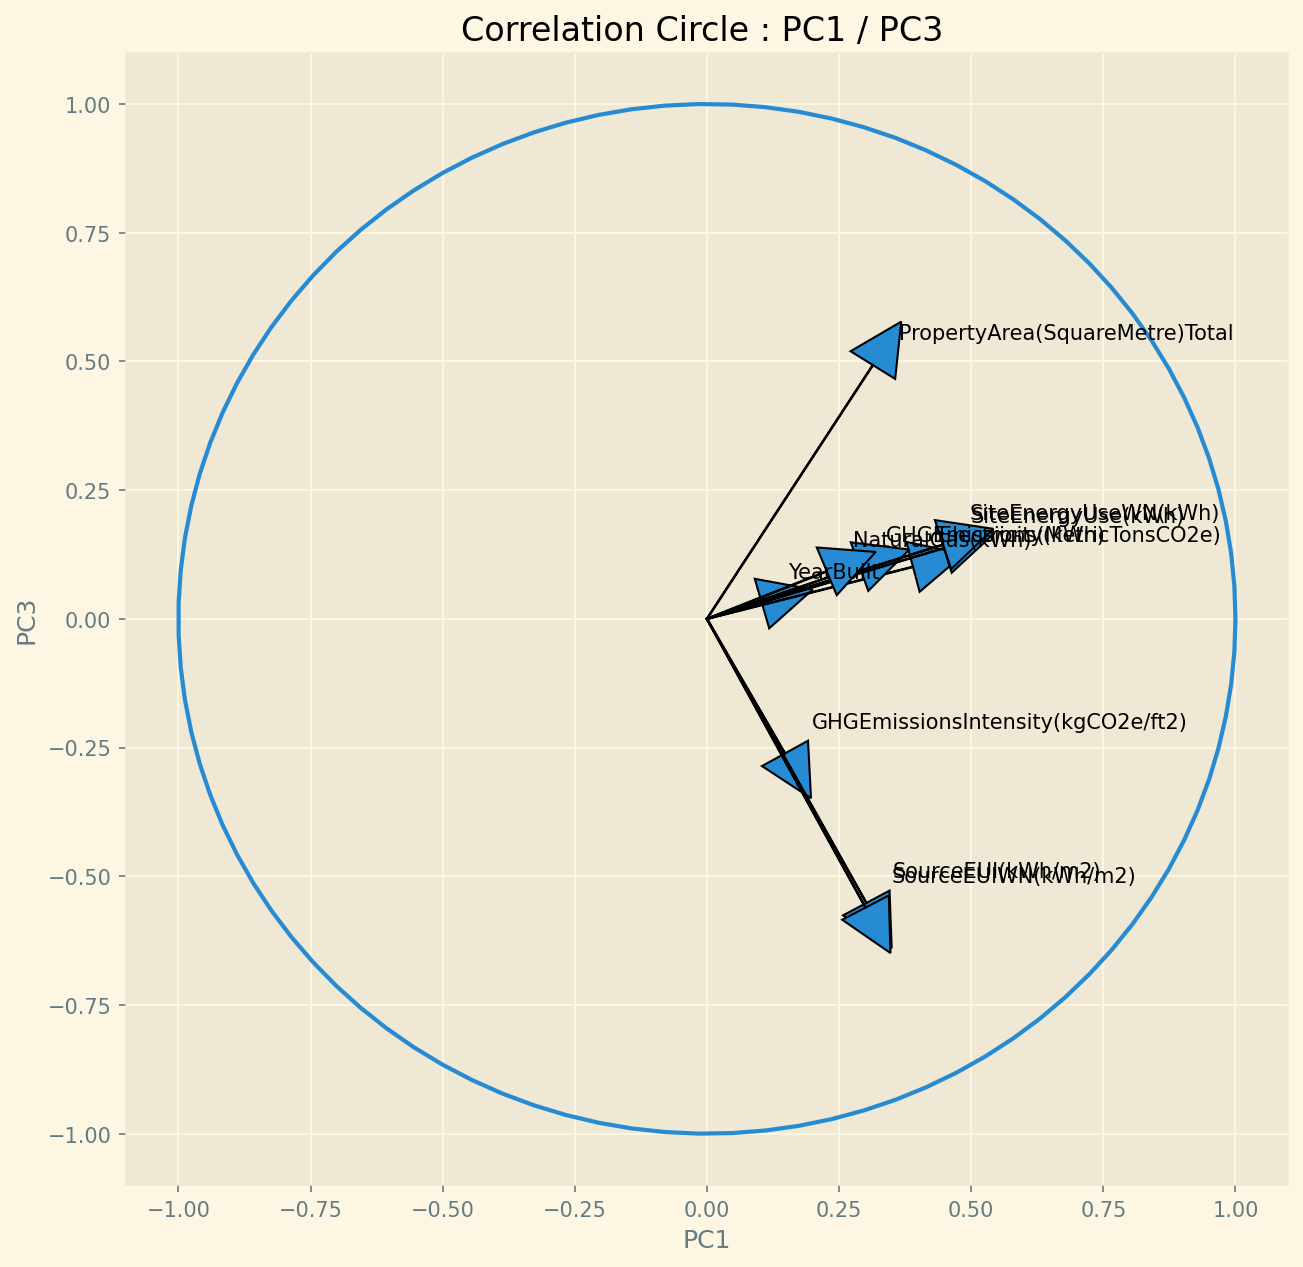

In [39]:
display_circles(pca=pca, pca_cols=columns_pca, couple_pc=(0, 2))


##### Verification : 
- Les fleches du cercle de corrélation PC1/PC3 ont un angle proche de 45 degrés / 135 degrés, indicant une similitude des deux composants principaux en se basant sur les valeurs absolues


In [40]:
pca_prep = data_pca


In [41]:
columns = [f"PC{idx + 1}" for idx in range(pca.n_components_)]
df_pca = pd.DataFrame(pca.transform(pca_prep), columns=columns, index=pca_prep.index)

df_pca.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
OSEBuildingID,,,,,,,,,,
1,2.465292e+06,-261789.405551,760557.993060,398334.030877,-5.409387e+05,-510027.736892,-1.605470e+06,-639448.257014,562274.759195,4409.224253
2,2.953300e+06,370202.945888,942831.899405,191900.235032,-1.366982e+06,-137603.356626,-1.770487e+06,-672333.843537,639172.653044,24264.991794
5,2.242051e+06,-65993.445204,699901.840945,296910.614740,-6.548462e+05,-355808.196127,-1.418043e+06,-687665.855607,633607.866161,26751.432326
10,2.070967e+06,111201.473437,654079.483819,192781.648480,-8.115539e+05,-193704.825484,-1.276219e+06,-436793.346896,385529.797581,-9376.695365
17,2.094650e+06,337979.643752,673566.264928,115641.498770,-1.016392e+06,-64946.211174,-1.230169e+06,-665184.021285,709019.735392,105913.706008


In [42]:
## Removing cols from PC3 to PC 10

df_pca.drop(columns=[f"PC{idx}" for idx in range(3, 11)], inplace=True)


In [43]:
# Renaming PC1 to Energy_consumption and PC2 to Pollution_generated

df_pca.rename(columns={
        "PC1": "Energy_consumption_(PC1)",
        "PC2": "Pollution_generated_(PC2)"
        },
        inplace=True
    )


In [44]:
# Adding Baseline and other infos
# Ignoring Largest property use type : too similar to primary property type

additionnal_infos = df_seattle[
        [
        "ENERGYSTARScore", "Neighborhood", "PrimaryPropertyType",
        ]
    ]

df_pca = df_pca.join(additionnal_infos, how="outer")


In [45]:
print(df_pca.shape)
df_pca.head()


(868, 5)


,Energy_consumption_(PC1),Pollution_generated_(PC2),ENERGYSTARScore,Neighborhood,PrimaryPropertyType
OSEBuildingID,,,,,
1,2.465292e+06,-261789.405551,60.0,DOWNTOWN,Hotel
2,2.953300e+06,370202.945888,61.0,DOWNTOWN,Hotel
5,2.242051e+06,-65993.445204,56.0,DOWNTOWN,Hotel
10,2.070967e+06,111201.473437,27.0,DOWNTOWN,Hotel
17,2.094650e+06,337979.643752,48.0,DOWNTOWN,Hotel


In [46]:
# Scaling

scale_ignore = ["Neighborhood", "PrimaryPropertyType", "ENERGYSTARScore"]
df_pca = scale_df(dataframe_to_scale=df_pca, constant_col=scale_ignore)


In [47]:
## reapplication of OHE

# Neighborhood

df_pca["Neighborhood"] = df_pca["Neighborhood"].apply(str.upper)

ohe_nbhood = preprocessing.OneHotEncoder()

transformed = ohe_nbhood.fit_transform(df_pca[["Neighborhood"]])

df_pca[ohe_nbhood.categories_[0]] = transformed.toarray()

cols_nbhood = list(ohe_nbhood.categories_[0])

rename_hood = dict.fromkeys(cols_nbhood)

for key in rename_hood.keys():
    rename_hood[key] = f"ohe_nbhood_{key}"

df_pca.rename(columns=rename_hood, inplace=True)
ohe_ptype = preprocessing.OneHotEncoder()

transformed = ohe_ptype.fit_transform(df_pca[["PrimaryPropertyType"]])

df_pca[ohe_ptype.categories_[0]] = transformed.toarray()

cols_ptype = list(ohe_ptype.categories_[0])

rename_ptype = dict.fromkeys(cols_ptype)

for key in rename_ptype.keys():
    rename_ptype[key] = f"ohe_ptype_{key}"

df_pca.rename(columns=rename_ptype, inplace=True)

df_pca.drop(columns=["Neighborhood", "PrimaryPropertyType"], inplace=True)  # Removing encoded cols


In [48]:
df_pca.to_csv("./data/seattle_scaled_clean_data.csv")
